# Loan Cancellation Problem

## The problem:
Marketplace lenders list customers’ loans for funding without verifying their information. If a loan is successfully funded, they are asked for additional documentation. The loan is originated only if they comply, otherwise it is cancelled. Loans may also be cancelled for other reasons, such as a customer declining the loan, or a loan not being fully funded.

Loan cancellations do hurt returns, since they add a few days of cash drag: the money put towards them could have instead been deployed to other loans. The problem is to predict whether a loan will be successfully originated or not.

The target variable is `EnumListingStatus`: it is `6` if a loan was originated, or `7` if it was cancelled.

Goal: Build a model to predict this variable and set up an experiment to validate its performance using ROC AUC.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data.csv')

# Data Munging

In [4]:
df.head(10)

,ListingNumber,ListingID,DateCreditPulled,DateListingStart,DateListingCreation,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield,...,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan
0,973605,973605,2013-10-13 01:50:58,2014-01-26 19:00:08.887000,2013-10-13 01:50:56.287000,7,15000,True,B,0.1520,...,33,2,8,1,True,3,2014-01-26 18:28:42.477000,NaN,True,False
1,981099,981099,2013-10-15 15:22:06,2014-01-10 00:00:16.530000,2013-10-15 15:22:03.990000,7,15000,True,B,0.1485,...,53,1,2,1,True,2,2014-01-09 23:49:48.150000,NaN,True,False
2,1025766,1025766,2013-11-06 23:09:36,2014-01-22 01:00:30.420000,2013-11-06 23:09:33.137000,6,4000,True,D,0.1985,...,15,2,3,2,False,1,NaN,NaN,False,True
3,1003835,1003835,2013-11-08 02:25:29,2014-01-03 00:00:09.013000,2013-11-08 02:25:27.187000,7,10000,True,A,0.1199,...,8,0,0,0,False,3,2014-01-02 23:47:33.943000,NaN,True,False
4,1011335,1011335,2013-11-11 22:08:44,2014-01-10 01:02:19.547000,2013-11-11 22:08:41.660000,6,20000,True,B,0.1340,...,39,3,7,5,False,1,NaN,NaN,False,True
5,1010105,1010105,2013-11-11 17:57:36,2014-01-09 16:00:25.610000,2013-11-11 17:57:33.190000,6,10000,True,D,0.2125,...,45,2,5,2,True,3,2014-01-09 15:50:28.617000,NaN,True,False
6,1029573,1029573,2013-11-11 13:54:40,2014-01-02 16:00:25.513000,2013-11-11 13:54:37.193000,6,15000,True,AA,0.0709,...,30,6,4,5,True,3,2014-01-02 15:30:27.903000,NaN,True,False
7,1014296,1014296,2013-11-13 00:25:25,2014-01-02 16:00:14.767000,2013-11-13 00:25:23.517000,6,7000,True,AA,0.0669,...,9,0,0,0,False,2,2014-01-02 15:30:28.487000,NaN,True,False
8,1009580,1009580,2013-11-11 15:25:22,2014-01-09 16:00:12.007000,2013-11-11 15:25:17.693000,6,5000,True,B,0.1214,...,31,6,5,4,False,2,2014-01-09 15:50:28.880000,NaN,True,False
9,743482,743482,2013-11-11 23:34:31,2014-01-26 20:00:31.670000,2013-04-03 21:51:20.923000,7,19000,True,B,0.1214,...,35,0,0,0,True,1,NaN,NaN,False,True


# 1) Examine First 10 columns

In [5]:
df.ix[:,0:10].head()

,ListingNumber,ListingID,DateCreditPulled,DateListingStart,DateListingCreation,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield
0,973605,973605,2013-10-13 01:50:58,2014-01-26 19:00:08.887000,2013-10-13 01:50:56.287000,7,15000,True,B,0.1520
1,981099,981099,2013-10-15 15:22:06,2014-01-10 00:00:16.530000,2013-10-15 15:22:03.990000,7,15000,True,B,0.1485
2,1025766,1025766,2013-11-06 23:09:36,2014-01-22 01:00:30.420000,2013-11-06 23:09:33.137000,6,4000,True,D,0.1985
3,1003835,1003835,2013-11-08 02:25:29,2014-01-03 00:00:09.013000,2013-11-08 02:25:27.187000,7,10000,True,A,0.1199
4,1011335,1011335,2013-11-11 22:08:44,2014-01-10 01:02:19.547000,2013-11-11 22:08:41.660000,6,20000,True,B,0.1340


In [6]:
df.ix[:,0:10].describe()

,ListingNumber,ListingID,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,LenderYield
count,252469.000000,252469.000000,252469.000000,252469.000000,252469,252469.000000
mean,1854904.385738,1854904.385738,6.334366,13698.220015,0.966946,0.130932
std,435120.292984,435120.292984,0.471769,7887.047333,0.178777,0.057614
min,743482.000000,743482.000000,6.000000,2000.000000,False,0.000500
25%,1478978.000000,1478978.000000,6.000000,8000.000000,1,0.092900
50%,1848023.000000,1848023.000000,6.000000,12000.000000,1,0.125000
75%,2216547.000000,2216547.000000,7.000000,20000.000000,1,0.166500
max,2715258.000000,2715258.000000,7.000000,35000.000000,True,0.302500


## Description of Each Column (0-9)
    0. `ListingNumber` - Loan Identifier number. Is this number unique?
    1. `ListingID` - Appears to be duplicate of `ListingNumber`
    2. `DateCreditPulled` - Date that Credit report was run in some type of Datetime format. Decompose into different date and time elements
    3. `DateListingStar` - Starting Date of Loan Listing? Decompose into different date and time elements
    4. `DateListingCreation` - Creation Date of Loan Listing?
    5. `EnumListingStatus` - Target Variable to Predict (can take values of `6` (Loan originated) or `7` (Loan application canceled). Verify that unique values are only `6` or `7`. Will want to convert to `0` and `1`.*
    6.  `DolLoanAmountRequested` - Amount of Loan Requested in Dollars
    7.  `BoolPartialFundingApproved` - Partial Funding Approved as a Boolean, Check to see if values or `0` or `1`.
    8.  `CreditGrade` - Some type of Credit rating. Determine unique values and how to treat it (Ordinal?)
    9. `LenderYield` - Definition: The lender yield is the interest rate minus the expected fee payments
    
* Look at whether the classes, 6 and 7, are distributed. Do we need stratified cross-validation?

<hr>

### Are `ListingNumber` and `ListingID` the same?

In [7]:
# subtract two columns from one another and sum them.
(df.ListingNumber - df.ListingID).sum()

0

### Yes, ListingNumber and ListingID are duplicates
So we can drop ListingID

In [8]:
df.drop('ListingID', 1, inplace=True)

In [9]:
df.ix[:,0:9].head()

,ListingNumber,DateCreditPulled,DateListingStart,DateListingCreation,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield
0,973605,2013-10-13 01:50:58,2014-01-26 19:00:08.887000,2013-10-13 01:50:56.287000,7,15000,True,B,0.1520
1,981099,2013-10-15 15:22:06,2014-01-10 00:00:16.530000,2013-10-15 15:22:03.990000,7,15000,True,B,0.1485
2,1025766,2013-11-06 23:09:36,2014-01-22 01:00:30.420000,2013-11-06 23:09:33.137000,6,4000,True,D,0.1985
3,1003835,2013-11-08 02:25:29,2014-01-03 00:00:09.013000,2013-11-08 02:25:27.187000,7,10000,True,A,0.1199
4,1011335,2013-11-11 22:08:44,2014-01-10 01:02:19.547000,2013-11-11 22:08:41.660000,6,20000,True,B,0.1340


<hr>

### Confirm that DateCreditPulled and DateListingCreation are different

In [10]:
import datetime
((pd.to_datetime(df.DateCreditPulled, format='%Y-%m-%d').apply(lambda x: x.date())) 
 != (pd.to_datetime(df.DateListingCreation, format='%Y-%m-%d').apply(lambda x: x.date()))).sum()

34548

### DateCreditPulled and DateListingCreation are NOT the same. 
There are 34,548 rows where DateCreditPulled and DateListingCreation are different

<hr>

## Separating the Date columns into Features and Add additional Date Features

* Year
* Month
* Day
* day_of_week
* day_of_year
* weekofyear
* is_month_start
* is_month_end

For the following:
* DateCreditPulled
* DateListingStart
* DateListingCreation

In [11]:
from numpy import double
## DateCreditPulled
df['DateCreditPulled_Year'] = df.DateCreditPulled.apply(lambda x: x.split('-')[0]).astype(double)
df['DateCreditPulled_Month'] = df.DateCreditPulled.apply(lambda x: x.split('-')[1]).astype(double)
df['DateCreditPulled_Day'] = df.DateCreditPulled.apply(lambda x: x.split('-')[2]).apply(lambda x: x.split(' ')[0]).astype(double)
# Convert to Datetime
df['DateCreditPulled'] = pd.to_datetime(df['DateCreditPulled'])
# Addtional Date Features
df['DateCreditPulled_day_of_week'] = df['DateCreditPulled'].dt.dayofweek.astype(double)
df['DateCreditPulled_day_of_year'] = df['DateCreditPulled'].dt.dayofyear.astype(double)
df['DateCreditPulled_weekofyear'] = df['DateCreditPulled'].dt.weekofyear.astype(double)
df['DateCreditPulled_is_month_start'] = df['DateCreditPulled'].dt.is_month_start.astype(int).astype(double)
df['DateCreditPulled_is_month_end'] = df['DateCreditPulled'].dt.is_month_end.astype(int).astype(double)

## DateListingStart
df['DateListingStart_Year'] = df.DateListingStart.apply(lambda x: x.split('-')[0]).astype(double)
df['DateListingStart_Month'] = df.DateListingStart.apply(lambda x: x.split('-')[1]).astype(double)
df['DateListingStart_Day'] = df.DateListingStart.apply(lambda x: x.split('-')[2]).apply(lambda x: x.split(' ')[0]).astype(double)
# Convert to Datetime
df['DateListingStart'] = pd.to_datetime(df['DateListingStart'])
# Addtional Date Features
df['DateListingStart_day_of_week'] = df['DateListingStart'].dt.dayofweek.astype(double)
df['DateListingStart_day_of_year'] = df['DateListingStart'].dt.dayofyear.astype(double)
df['DateListingStart_weekofyear'] = df['DateListingStart'].dt.weekofyear.astype(double)
df['DateListingStart_is_month_start'] = df['DateListingStart'].dt.is_month_start.astype(int).astype(double)
df['DateListingStart_is_month_end'] = df['DateListingStart'].dt.is_month_end.astype(int).astype(double)

## DateListingCreation
df['DateListingCreation_Year'] = df.DateListingCreation.apply(lambda x: x.split('-')[0]).astype(double)
df['DateListingCreation_Month'] = df.DateListingCreation.apply(lambda x: x.split('-')[1]).astype(double)
df['DateListingCreation_Day'] = df.DateListingCreation.apply(lambda x: x.split('-')[2]).apply(lambda x: x.split(' ')[0]).astype(double)
# Convert to Datetime
df['DateListingCreation'] = pd.to_datetime(df['DateListingCreation'])
# Addtional Date Features
df['DateListingCreation_day_of_week'] = df['DateListingCreation'].dt.dayofweek.astype(double)
df['DateListingCreation_day_of_year'] = df['DateListingCreation'].dt.dayofyear.astype(double)
df['DateListingCreation_weekofyear'] = df['DateListingCreation'].dt.weekofyear.astype(double)
df['DateListingCreation_is_month_start'] = df['DateListingCreation'].dt.is_month_start.astype(int).astype(double)
df['DateListingCreation_is_month_end'] = df['DateListingCreation'].dt.is_month_end.astype(int).astype(double)

# total of 24 new features created

In [12]:
# rearrange columns so new columns are adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:4] + cols[-24:] + cols[4:-24]
df = df[cols]

In [13]:
df.ix[:,0:33].head()

,ListingNumber,DateCreditPulled,DateListingStart,DateListingCreation,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,...,DateListingCreation_day_of_week,DateListingCreation_day_of_year,DateListingCreation_weekofyear,DateListingCreation_is_month_start,DateListingCreation_is_month_end,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield
0,973605,2013-10-13 01:50:58,2014-01-26 19:00:08.887,2013-10-13 01:50:56.287,2013,10,13,6,286,41,...,6,286,41,0,0,7,15000,True,B,0.1520
1,981099,2013-10-15 15:22:06,2014-01-10 00:00:16.530,2013-10-15 15:22:03.990,2013,10,15,1,288,42,...,1,288,42,0,0,7,15000,True,B,0.1485
2,1025766,2013-11-06 23:09:36,2014-01-22 01:00:30.420,2013-11-06 23:09:33.137,2013,11,6,2,310,45,...,2,310,45,0,0,6,4000,True,D,0.1985
3,1003835,2013-11-08 02:25:29,2014-01-03 00:00:09.013,2013-11-08 02:25:27.187,2013,11,8,4,312,45,...,4,312,45,0,0,7,10000,True,A,0.1199
4,1011335,2013-11-11 22:08:44,2014-01-10 01:02:19.547,2013-11-11 22:08:41.660,2013,11,11,0,315,46,...,0,315,46,0,0,6,20000,True,B,0.1340


In [14]:
df.ix[:,0:33].dtypes

ListingNumber                                  int64
DateCreditPulled                      datetime64[ns]
DateListingStart                      datetime64[ns]
DateListingCreation                   datetime64[ns]
DateCreditPulled_Year                        float64
DateCreditPulled_Month                       float64
DateCreditPulled_Day                         float64
DateCreditPulled_day_of_week                 float64
DateCreditPulled_day_of_year                 float64
DateCreditPulled_weekofyear                  float64
DateCreditPulled_is_month_start              float64
DateCreditPulled_is_month_end                float64
DateListingStart_Year                        float64
DateListingStart_Month                       float64
DateListingStart_Day                         float64
DateListingStart_day_of_week                 float64
DateListingStart_day_of_year                 float64
DateListingStart_weekofyear                  float64
DateListingStart_is_month_start              f

## Create new Feature of delay between Listing Creation and Listing Start

In [15]:
df['DateListingDelay'] = (df.DateListingStart - df.DateListingCreation).dt.days

In [16]:
df['DateListingDelay'].head()

0    105
1     86
2     76
3     55
4     59
Name: DateListingDelay, dtype: int64

In [17]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:4] + cols[-1:] + cols[4:-1]
df = df[cols]

In [18]:
df.groupby(['DateCreditPulled_Year', 'DateCreditPulled_Month', 'EnumListingStatus']).mean()

ListingNumber  \
DateCreditPulled_Year DateCreditPulled_Month EnumListingStatus                   
2013                  10                     7                   977352.000000   
                      11                     6                  1026442.904762   
                                             7                   980131.714286   
                      12                     6                  1089925.726218   
                                             7                  1093054.110599   
2014                  1                      6                  1129567.140257   
                                             7                  1129535.703782   
                      2                      6                  1190262.289312   
                                             7                  1190178.789269   
                      3                      6                  1262877.705294   
                                             7                  1262894.115164   
                      4                      6                  1323748.593865   
                                             7                  1324832.075165   
                      5                      6                  1411483.243160   
                                             7                  1410435.050614   
                      6                      6                  1494878.643860   
                                             7                  1493834.404943   
                      7                      6                  1598742.279502   
                                             7                  1597460.444358   
                      8                      6                  1708986.998085   
                                             7                  1708812.956423   
                      9                      6                  1821184.806187   
                                             7                  1820686.199489   
                      10                     6                  1934769.594971   
                                             7                  1934816.724286   
                      11                     6                  2039346.212895   
                                             7                  2039567.351304   
                      12                     6                  2155485.808211   
                                             7                  2156877.787164   
2015                  1                      6                  2295852.485105   
                                             7                  2297524.905716   
                      2                      6                  2421132.990632   
                                             7                  2416190.051486   
                      3                      6                  2537683.616671   
                                             7                  2538045.000310   

                                                                DateListingDelay  \
DateCreditPulled_Year DateCreditPulled_Month EnumListingStatus                     
2013                  10                     7                         95.500000   
                      11                     6                         56.190476   
                                             7                         86.428571   
                      12                     6                         11.993039   
                                             7                         10.470046   
2014                  1                      6                          2.749632   
                                             7                          2.773374   
                      2                      6                          3.787560   
                                             7                          3.055065   
                      3                      6                          3.193185   
                      

There was a significant change in the Listing Delay in 2013 versus 2014 and 2015 

In [19]:
df.columns.tolist()

['ListingNumber',
 'DateCreditPulled',
 'DateListingStart',
 'DateListingCreation',
 'DateListingDelay',
 'DateCreditPulled_Year',
 'DateCreditPulled_Month',
 'DateCreditPulled_Day',
 'DateCreditPulled_day_of_week',
 'DateCreditPulled_day_of_year',
 'DateCreditPulled_weekofyear',
 'DateCreditPulled_is_month_start',
 'DateCreditPulled_is_month_end',
 'DateListingStart_Year',
 'DateListingStart_Month',
 'DateListingStart_Day',
 'DateListingStart_day_of_week',
 'DateListingStart_day_of_year',
 'DateListingStart_weekofyear',
 'DateListingStart_is_month_start',
 'DateListingStart_is_month_end',
 'DateListingCreation_Year',
 'DateListingCreation_Month',
 'DateListingCreation_Day',
 'DateListingCreation_day_of_week',
 'DateListingCreation_day_of_year',
 'DateListingCreation_weekofyear',
 'DateListingCreation_is_month_start',
 'DateListingCreation_is_month_end',
 'EnumListingStatus',
 'DolLoanAmountRequested',
 'BoolPartialFundingApproved',
 'CreditGrade',
 'LenderYield',
 'BorrowerRate',
 'Nu

<hr>

## Missing Data in the first set of columns?

In [20]:
pd.isnull(df.ix[:,0:34]).any()

ListingNumber                         False
DateCreditPulled                      False
DateListingStart                      False
DateListingCreation                   False
DateListingDelay                      False
DateCreditPulled_Year                 False
DateCreditPulled_Month                False
DateCreditPulled_Day                  False
DateCreditPulled_day_of_week          False
DateCreditPulled_day_of_year          False
DateCreditPulled_weekofyear           False
DateCreditPulled_is_month_start       False
DateCreditPulled_is_month_end         False
DateListingStart_Year                 False
DateListingStart_Month                False
DateListingStart_Day                  False
DateListingStart_day_of_week          False
DateListingStart_day_of_year          False
DateListingStart_weekofyear           False
DateListingStart_is_month_start       False
DateListingStart_is_month_end         False
DateListingCreation_Year              False
DateListingCreation_Month       

### No missing Data in fields 1 to 34
<hr>

### Target Variable is EnumListingStatus
Convert Class Labels to 0 and 1 (instead of 6 and 7)

In [21]:
# First check Unique Values in EnumListingStatus
pd.unique(df.EnumListingStatus.ravel())

array([7, 6], dtype=int64)

In [22]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
df['EnumListingStatus'] = class_le.fit_transform(df['EnumListingStatus'].values)
df['EnumListingStatus'].head(10)

0    1
1    1
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    1
Name: EnumListingStatus, dtype: int64

Use the inverse_transform method to transform the integer class labels back into their original  representation:

In [23]:
class_le.inverse_transform(df['EnumListingStatus'])

array([7, 7, 6, ..., 6, 6, 6], dtype=int64)

### Determine balance of `EnumListingStatus`

In [24]:
pd.value_counts(df['EnumListingStatus'].values, sort=False)

0    168052
1     84417
dtype: int64

There are approximately half as many cancellations as originations so we do not need to do stratified cross-validation.

<hr>
### Examine DolLoanAmountRequested

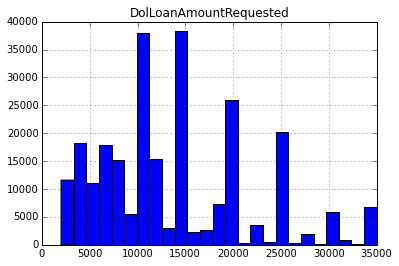

In [25]:
# matplotlib
import matplotlib as mpl
# matplotlib plotting functions
import matplotlib.pyplot as plt
# we want our plots inline
%matplotlib inline
dfh = pd.DataFrame(df.DolLoanAmountRequested)
dfh.hist(bins = 25);

<hr>
### Convert to Boolean data type `BoolPartialFundingApproved` to integer

In [26]:
df['BoolPartialFundingApproved'].dtypes

dtype('bool')

In [27]:
df['BoolPartialFundingApproved'] = df['BoolPartialFundingApproved'].astype(int)

In [28]:
df['BoolPartialFundingApproved'].head()

0    1
1    1
2    1
3    1
4    1
Name: BoolPartialFundingApproved, dtype: int32

<hr>
# CreditGrade feature

In [29]:
# First check Unique Values in CreditGrade
pd.unique(df.CreditGrade.ravel())

array(['B', 'D', 'A', 'AA', 'C', 'E', 'HR'], dtype=object)

### Convert CreditGrade Feature
Credit Grade is Ordinal with the order, best to worst, as AA, A, B, C, D, E, HR. We need define the mapping manually.

In [30]:
credit_mapping = {
    'AA' : 7,
    'A' : 6,
    'B' : 5,
    'C' : 4,
    'D' : 3,
    'E' : 2,
    'HR' : 1,   
}

In [31]:
df['CreditGrade'] = df['CreditGrade'].map(credit_mapping)

In [32]:
df['CreditGrade'].head(10)

0    5
1    5
2    3
3    6
4    5
5    3
6    7
7    7
8    5
9    5
Name: CreditGrade, dtype: int64

### To transform integer values back to original string representation

In [33]:
inv_size_mapping = {v: k for k, v in credit_mapping.items()}

In [34]:
df['CreditGrade'].map(inv_size_mapping).head(10)

0     B
1     B
2     D
3     A
4     B
5     D
6    AA
7    AA
8     B
9     B
Name: CreditGrade, dtype: object

### Drop Columns we don't need anymore

In [35]:
df.drop(['DateCreditPulled','DateListingStart', 'DateListingCreation'], inplace=True, axis=1)

In [36]:
df.ix[:,0:31].head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,DateListingCreation_day_of_week,DateListingCreation_day_of_year,DateListingCreation_weekofyear,DateListingCreation_is_month_start,DateListingCreation_is_month_end,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield
0,973605,105,2013,10,13,6,286,41,0,0,...,6,286,41,0,0,1,15000,1,5,0.1520
1,981099,86,2013,10,15,1,288,42,0,0,...,1,288,42,0,0,1,15000,1,5,0.1485
2,1025766,76,2013,11,6,2,310,45,0,0,...,2,310,45,0,0,0,4000,1,3,0.1985
3,1003835,55,2013,11,8,4,312,45,0,0,...,4,312,45,0,0,1,10000,1,6,0.1199
4,1011335,59,2013,11,11,0,315,46,0,0,...,0,315,46,0,0,0,20000,1,5,0.1340


<hr>
### Examine LenderYield

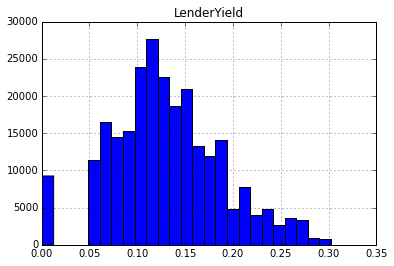

In [37]:
dfLY = pd.DataFrame(df.LenderYield)
dfLY.hist(bins = 25);

<hr>
# 2) Examine Second set of columns

In [38]:
df.ix[:,31:41].columns.tolist()

['BorrowerRate',
 'NumMonthsTerm',
 'DolMonthlyLoanPayment',
 'FICOScore',
 'ProsperScore',
 'EnumListingCategory',
 'DolMonthlyIncome',
 'BoolIncomeVerifiable',
 'FracDebtToIncomeRatio',
 'StrEmploymentStatus']

## Description of Each Column (31-40)
    31. `BorrowerRate` - Some type of borrowing ratio?
    32. `NumMonthsTerm` - Number of months of the term of the Loan
    33. `DolMonthlyLoanPayment` - Monthly Loan repayment in Dollars
    34. `FICOScore` - Fico Score
    35. `ProsperScore` - Prosper Score - Another type of Credit Score?
    36. `EnumListingCategory` - Another Type of numerical classification. Does not appear to be ordinal.
    37. `DolMonthlyIncome` - Monthly Income in Dollars, Maximum value of `10,000,000` is a good indication that there could be outliers, errors
    38. `BoolIncomeVerifiable` - Is income verifiable (in Boolean)? Check to see if unique values are only True of False. Convert to 0 and 1
    39. `FracDebtToIncomeRatio` - Ratio of Debt to Income. Maximum Value of 53.23 indicates there could be outliers. Also, it look like there is a lot of missing values in this column by looking at the column counts (252,469 - 236,862 = 15,607). Will need to figure out how to impute these values.
    40. `StrEmploymentStatus` - A classification of a person's employment status (employed, self-employed, etc.). Need to get unique  values and convert.

In [39]:
df.ix[:,31:41].head(10)

,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio,StrEmploymentStatus
0,0.1620,60,366.37,689,6,1,6000.0000,True,0.27,Employed
1,0.1585,60,363.58,709,8,1,7916.6667,True,0.35,Other
2,0.2085,36,150.39,669,6,1,2083.3333,True,0.53,Employed
3,0.1299,36,336.89,749,5,13,3750.0000,True,0.14,Employed
4,0.1440,60,469.52,649,11,1,9000.0000,True,0.16,Employed
5,0.2225,36,383.20,689,4,1,8416.6667,True,0.45,Employed
6,0.0809,36,470.67,689,11,3,6250.0000,False,NaN,Self-employed
7,0.0769,36,218.35,789,8,3,3333.3333,True,0.16,Employed
8,0.1314,36,168.81,669,7,1,6450.9167,True,0.15,Employed
9,0.1314,60,433.67,709,10,1,12500.0000,True,0.28,Employed


In [40]:
df.ix[:,31:41].describe()

,BorrowerRate,NumMonthsTerm,DolMonthlyLoanPayment,FICOScore,ProsperScore,EnumListingCategory,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio
count,252469.000000,252469.000000,252469.000000,252469.000000,252459.000000,252469.000000,252469.000000,252469,236862.000000
mean,0.145653,43.925821,410.170272,699.975858,6.637799,2.572819,6995.399571,0.938143,0.257345
std,0.052620,11.287230,230.729467,37.696744,2.489146,3.898659,27229.350999,0.240896,0.156545
min,0.060000,36.000000,40.300000,649.000000,2.000000,0.000000,0.000000,False,0.000000
25%,0.108900,36.000000,233.640000,669.000000,4.000000,1.000000,3916.666700,1,0.170000
50%,0.138500,36.000000,369.170000,689.000000,7.000000,1.000000,5416.666700,1,0.250000
75%,0.179000,60.000000,550.670000,729.000000,8.000000,1.000000,7666.666700,1,0.330000
max,0.312500,60.000000,1210.720000,835.000000,21.000000,21.000000,10000000.000000,True,53.230000


### Are there missing data in these columns?

In [41]:
pd.isnull(df.ix[:,31:41]).sum()

BorrowerRate                 0
NumMonthsTerm                0
DolMonthlyLoanPayment        0
FICOScore                    0
ProsperScore                10
EnumListingCategory          0
DolMonthlyIncome             0
BoolIncomeVerifiable         0
FracDebtToIncomeRatio    15607
StrEmploymentStatus          0
dtype: int64

### Relatively small number of missing values in ProsperScore and a lot missing data in FracDebtToIncomeRatio

In [42]:
df = df.dropna(subset=['ProsperScore'])

In [43]:
pd.isnull(df.ix[:,35:36]).sum()

ProsperScore    0
dtype: int64

### Impute missing value in FracDebtToIncomeRatio with mean
Could have also used Imputer from Sklearn

In [44]:
df['FracDebtToIncomeRatio'] = df.FracDebtToIncomeRatio.fillna(value=0.26)
pd.isnull(df.ix[:,31:41]).sum()

BorrowerRate             0
NumMonthsTerm            0
DolMonthlyLoanPayment    0
FICOScore                0
ProsperScore             0
EnumListingCategory      0
DolMonthlyIncome         0
BoolIncomeVerifiable     0
FracDebtToIncomeRatio    0
StrEmploymentStatus      0
dtype: int64

In [45]:
df['FracDebtToIncomeRatio'].dtypes

dtype('float64')

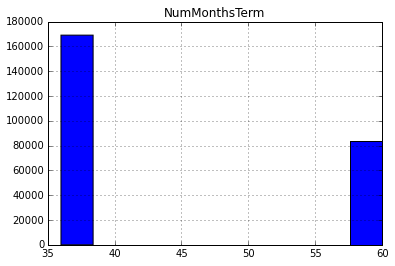

In [46]:
pd.DataFrame(df.NumMonthsTerm).hist(bins = 10);

### NumMonthsTerm appears to take on two values: 36 months and 60 months

In [47]:
# Check unique values
pd.unique(df.NumMonthsTerm.ravel())

array([60, 36], dtype=int64)

### Convert to Categorical / Binary

In [48]:
class_le = LabelEncoder()
df['NumMonthsTerm'] = class_le.fit_transform(df['NumMonthsTerm'].values)
df['NumMonthsTerm'].head(10)

0    1
1    1
2    0
3    0
4    1
5    0
6    0
7    0
8    0
9    1
Name: NumMonthsTerm, dtype: int64

In [49]:
# To convert back
class_le.inverse_transform(df['NumMonthsTerm'])

array([60, 60, 36, ..., 60, 36, 36], dtype=int64)

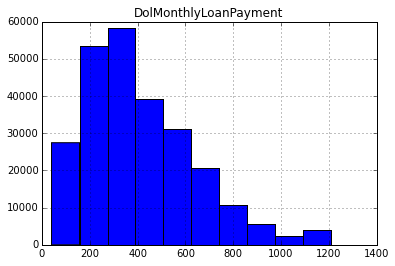

In [50]:
pd.DataFrame(df.DolMonthlyLoanPayment).hist(bins = 10);

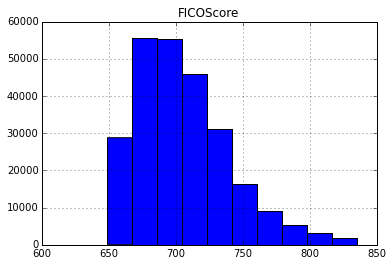

In [51]:
pd.DataFrame(df.FICOScore).hist(bins = 10);

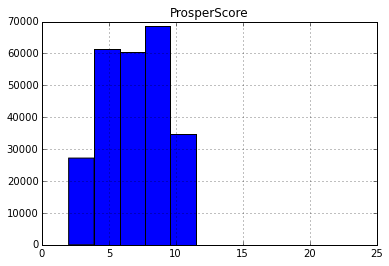

In [52]:
pd.DataFrame(df.ProsperScore).hist(bins = 10);

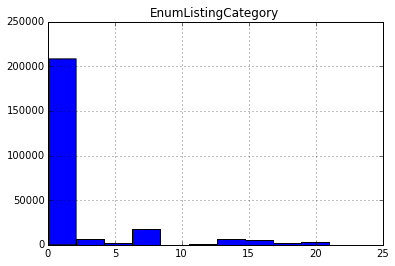

In [53]:
pd.DataFrame(df.EnumListingCategory).hist(bins = 10);

In [54]:
# Check unique values
pd.unique(df.EnumListingCategory.ravel())

array([ 1, 13,  3, 15, 14, 20,  2,  7,  6, 19, 12, 18,  8,  9, 16, 17, 11,
        0, 21], dtype=int64)

In [55]:
df.groupby(['EnumListingCategory']).mean().ix[:,26:31]

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,CreditGrade,LenderYield
EnumListingCategory,,,,,
0,0.355263,13969.741228,0.982456,4.820175,0.125847
1,0.322408,14232.577571,0.978337,4.775742,0.130055
2,0.352350,12948.360764,0.946669,4.709369,0.132825
3,0.421997,14921.323876,0.975401,4.485796,0.139794
6,0.374668,8397.778113,0.873782,4.659876,0.134631
7,0.376605,11806.218857,0.932868,4.796857,0.129893
8,0.330864,12978.501235,0.958025,4.716049,0.135170
9,0.343750,10354.031250,0.900000,4.737500,0.134952
11,0.336336,9439.028078,0.906907,4.792793,0.133894


In [56]:
df.groupby(['EnumListingCategory']).count()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan
EnumListingCategory,,,,,,,,,,,,,,,,,,,,,
0,228,228,228,228,228,228,228,228,228,228,...,228,228,228,228,228,228,216,2,228,228
1,195355,195355,195355,195355,195355,195355,195355,195355,195355,195355,...,195355,195355,195355,195355,195355,195355,180430,4873,195355,195355
2,12638,12638,12638,12638,12638,12638,12638,12638,12638,12638,...,12638,12638,12638,12638,12638,12638,11608,314,12638,12638
3,6301,6301,6301,6301,6301,6301,6301,6301,6301,6301,...,6301,6301,6301,6301,6301,6301,5757,252,6301,6301
6,2258,2258,2258,2258,2258,2258,2258,2258,2258,2258,...,2258,2258,2258,2258,2258,2258,2038,51,2258,2258
7,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,...,17756,17756,17756,17756,17756,17756,16383,544,17756,17756
8,405,405,405,405,405,405,405,405,405,405,...,405,405,405,405,405,405,364,12,405,405
9,160,160,160,160,160,160,160,160,160,160,...,160,160,160,160,160,160,148,4,160,160
11,333,333,333,333,333,333,333,333,333,333,...,333,333,333,333,333,333,306,6,333,333


Grouping by EnumListingCategory and examining the mean of the EnumListingStatus does not reveal any correlation between Listing status and Listing Category

This feature is heavily skewed towards Category 1. We might need to examine how we do cross-validation

### Assuming that these are categories and that there is no order to these numbers.
Will want to dummify this classification

In [57]:
EnumListingCategory_dummies = pd.get_dummies(df['EnumListingCategory'], prefix='EnumListingCategory')
# adding 19 additional columns 

In [58]:
df = pd.concat([df, EnumListingCategory_dummies], axis=1)

In [59]:
df.head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,EnumListingCategory_12,EnumListingCategory_13,EnumListingCategory_14,EnumListingCategory_15,EnumListingCategory_16,EnumListingCategory_17,EnumListingCategory_18,EnumListingCategory_19,EnumListingCategory_20,EnumListingCategory_21
0,973605,105,2013,10,13,6,286,41,0,0,...,0,0,0,0,0,0,0,0,0,0
1,981099,86,2013,10,15,1,288,42,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1025766,76,2013,11,6,2,310,45,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1011335,59,2013,11,11,0,315,46,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Drop EnumListingCategory Column
df.drop(['EnumListingCategory'], inplace=True, axis=1)

In [61]:
# step_1.drop(['dummy', 'c'], inplace=True, axis=1)
#  we want to get rid of one dummy variable to avoid the dummy variable trap
# arbitrarily can chose "EnumListingCategory_0", coefficients on the other columns would show effect of these features
# relative to "EnumListingCategory_0"

In [62]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:36] + cols[-19:] + cols[36:-19]
df = df[cols]

<hr>
### Examine DolMonthlyIncome
Maximum value of `10,000,000` is a good indication that there could be outliers, errors

In [63]:
df.ix[:,55:58].head(10)

,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio
0,6000.0000,True,0.27
1,7916.6667,True,0.35
2,2083.3333,True,0.53
3,3750.0000,True,0.14
4,9000.0000,True,0.16
5,8416.6667,True,0.45
6,6250.0000,False,0.26
7,3333.3333,True,0.16
8,6450.9167,True,0.15
9,12500.0000,True,0.28


In [64]:
df.ix[:,55:58].describe()

,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio
count,252459.000000,252459,252459.000000
mean,6995.568921,0.938144,0.257507
std,27229.873022,0.240894,0.151631
min,0.000000,False,0.000000
25%,3916.666700,1,0.180000
50%,5416.666700,1,0.260000
75%,7666.666700,1,0.330000
max,10000000.000000,True,53.230000


In [65]:
df.loc[(df['DolMonthlyIncome'] >= 500000)].groupby('EnumListingStatus').count()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,NumSatisfactoryAccounts,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan
EnumListingStatus,,,,,,,,,,,,,,,,,,,,,
0,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,6,0,9,9
1,58,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,55,2,58,58


### Cannot tell if these errors; misstated income

C:\Users\David\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


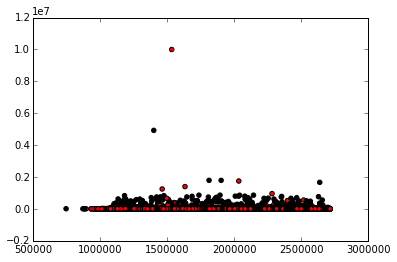

In [66]:
colors = np.where(df.EnumListingStatus == 0, 'r', 'k')
plt.scatter(df.ListingNumber, df.DolMonthlyIncome , c=colors)

<hr>
### Convert BoolIncomeVerifiable

In [67]:
df['BoolIncomeVerifiable'] = df['BoolIncomeVerifiable'].astype(int)

In [68]:
df['BoolIncomeVerifiable'].head()

0    1
1    1
2    1
3    1
4    1
Name: BoolIncomeVerifiable, dtype: int32

<hr>
### Examine FracDebtToIncomeRatio

In [69]:
df.loc[(df['FracDebtToIncomeRatio'] >= 1)].ix[:,:58]

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,EnumListingCategory_15,EnumListingCategory_16,EnumListingCategory_17,EnumListingCategory_18,EnumListingCategory_19,EnumListingCategory_20,EnumListingCategory_21,DolMonthlyIncome,BoolIncomeVerifiable,FracDebtToIncomeRatio
13329,1212594,0,2014,2,16,6,47,7,0,0,...,0,0,0,0,0,0,0,11.5833,1,53.23
14135,1162879,0,2014,2,19,2,50,8,0,0,...,0,0,0,0,1,0,0,150.0000,1,1.01
19761,1253229,9,2014,3,10,0,69,11,0,0,...,0,0,0,0,0,0,0,833.3333,1,1.78


### One value has a FracDebtToIncomeRatio = 53.23, which is much higher than typical values.
Drop this row

In [70]:
df = df[df.ListingNumber != 1212594]

<hr> 
### Examine StrEmploymentStatus

In [71]:
# Check unique values
pd.unique(df.StrEmploymentStatus.ravel())

array(['Employed', 'Other', 'Self-employed', 'Full-time', 'Part-time',
       'Not employed'], dtype=object)

### Need to dummify Feature

In [72]:
StrEmploymentStatus_dummies = pd.get_dummies(df['StrEmploymentStatus'], prefix='StrEmploymentStatus')
StrEmploymentStatus_dummies.head()

,StrEmploymentStatus_Employed,StrEmploymentStatus_Full-time,StrEmploymentStatus_Not employed,StrEmploymentStatus_Other,StrEmploymentStatus_Part-time,StrEmploymentStatus_Self-employed
0,1,0,0,0,0,0
1,0,0,0,1,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [73]:
df = pd.concat([df, StrEmploymentStatus_dummies], axis=1)

In [74]:
df.head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan,StrEmploymentStatus_Employed,StrEmploymentStatus_Full-time,StrEmploymentStatus_Not employed,StrEmploymentStatus_Other,StrEmploymentStatus_Part-time,StrEmploymentStatus_Self-employed
0,973605,105,2013,10,13,6,286,41,0,0,...,2014-01-26 18:28:42.477000,NaN,True,False,1,0,0,0,0,0
1,981099,86,2013,10,15,1,288,42,0,0,...,2014-01-09 23:49:48.150000,NaN,True,False,0,0,0,1,0,0
2,1025766,76,2013,11,6,2,310,45,0,0,...,NaN,NaN,False,True,1,0,0,0,0,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,2014-01-02 23:47:33.943000,NaN,True,False,1,0,0,0,0,0
4,1011335,59,2013,11,11,0,315,46,0,0,...,NaN,NaN,False,True,1,0,0,0,0,0


In [75]:
# Drop StrEmploymentStatus Column
df.drop(['StrEmploymentStatus'], inplace=True, axis=1)

In [76]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:58] + cols[-6:] + cols[58:-6]
df = df[cols]

<hr>
# 3) Examine Third set of columns

In [77]:
df.ix[:,64:74].columns.tolist()

['StrOccupation',
 'NumMonthsEmployed',
 'StrState',
 'StrBorrowerCity',
 'NumPriorProsperLoansActive',
 'NumPriorProsperLoans',
 'DolPriorProsperLoansPrincipalBorrowed',
 'DolPriorProsperLoansPrincipalOutstanding',
 'DolPriorProsperLoansBalanceOutstanding',
 'NumPriorProsperLoansCyclesBilled']

### Description of Each Column (64-74)
* `StrOccupation` - Type of occupation, classification; How many categories? need to dummify?, A lot of missing values
* `NumMonthsEmployed` - Self-explanatory, There are negative values which don't make much sense. 18 values are missing
* `StrState` - State, need to dummify
* `StrBorrowerCity` - City, how many unique values are there? Would there be too many to dummify?
* `NumPriorProsperLoansActive`- Number of Prior Prosper Loans Active
* `NumPriorProsperLoans`- Number of Prior Prosper Loans 
* `DolPriorProsperLoansPrincipalBorrowed` - Principal of Prosper Loan Borrowed - A lot of missing values, set to 0?
* `DolPriorProsperLoansPrincipalOutstanding` - Principal of Prosper Loan Outstanding - A lot of missing values, set to 0?
* `DolPriorProsperLoansBalanceOutstanding`  - Balance of Prosper Loan Outstanding - A lot of missing values, set to 0?
* `NumPriorProsperLoansCyclesBilled` - Number of Prosper Loan Cycles Billed - A lot of missing values, set to 0?

In [78]:
df.ix[:,64:74].head(10)

,StrOccupation,NumMonthsEmployed,StrState,StrBorrowerCity,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled
0,Tradesman - Mechanic,445,VA,VIRGINIA BCH,0,0,NaN,NaN,NaN,NaN
1,NaN,32,CA,ACTON,0,0,NaN,NaN,NaN,NaN
2,Professional,4,MN,MINNEAPOLIS,1,3,14400,4440.72,4442.52,52
3,Medical Technician,2,OK,OKLAHOMA CITY,0,0,NaN,NaN,NaN,NaN
4,Executive,90,MN,BELLE PLAINE,0,1,2600,0.00,0.00,33
5,Professional,125,AL,MONTGOMERY,0,0,NaN,NaN,NaN,NaN
6,Food Service,9,FL,MARY ESTHER,0,1,4000,0.00,0.00,10
7,Retail Management,22,NY,STATEN ISLAND,0,0,NaN,NaN,NaN,NaN
8,Other,268,VA,HERNDON,0,0,NaN,NaN,NaN,NaN
9,Pharmacist,190,VA,CULPEPER,0,0,NaN,NaN,NaN,NaN


In [79]:
df.ix[:,64:74].describe()

,NumMonthsEmployed,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled
count,252440.000000,252458.000000,252458.000000,16288.000000,16288.000000,16288.000000,16288.000000
mean,108.655241,0.042851,0.088910,12308.294812,5007.240756,5040.344329,20.060842
std,104.204254,0.202560,0.396555,8909.040763,5652.723653,5686.125280,20.468463
min,-9.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,5000.000000,0.000000,0.000000,9.000000
50%,79.000000,0.000000,0.000000,10000.000000,3103.340000,3124.635000,12.000000
75%,160.000000,0.000000,0.000000,15000.000000,8428.825000,8477.217500,24.000000
max,662.000000,2.000000,10.000000,84499.000000,32543.340000,32750.190000,154.000000


### Are there any missing data in these columns?


In [80]:
pd.isnull(df.ix[:,64:74]).sum()

StrOccupation                                18423
NumMonthsEmployed                               18
StrState                                         0
StrBorrowerCity                                  0
NumPriorProsperLoansActive                       0
NumPriorProsperLoans                             0
DolPriorProsperLoansPrincipalBorrowed       236170
DolPriorProsperLoansPrincipalOutstanding    236170
DolPriorProsperLoansBalanceOutstanding      236170
NumPriorProsperLoansCyclesBilled            236170
dtype: int64

<hr>
### Examine StrOccupation
* Check Unique Values
* Take care of missing Values
* Dummify StrOccupation

In [81]:
# Check unique values
pd.unique(df.StrOccupation.ravel())

array(['Tradesman - Mechanic', nan, 'Professional', 'Medical Technician',
       'Executive', 'Food Service', 'Retail Management', 'Other',
       'Pharmacist', 'Attorney', 'Food Service Management',
       'Sales - Retail', 'Civil Service', 'Professor', 'Nurse (RN)',
       'Analyst', 'Computer Programmer', 'Military Enlisted',
       'Police Officer/Correction Officer', 'Truck Driver', 'Doctor',
       'Landscaping', 'Skilled Labor', 'Administrative Assistant',
       'Nurse (LPN)', 'Engineer - Mechanical', 'Accountant/CPA',
       'Construction', 'Teacher', 'Clerical', 'Principal', 'Dentist',
       'Laborer', 'Engineer - Electrical', 'Sales - Commission',
       "Teacher's Aide", 'Postal Service', 'Fireman', 'Social Worker',
       'Chemist', 'Psychologist', 'Tradesman - Electrician',
       'Pilot - Private/Commercial', 'Realtor', 'Waiter/Waitress',
       'Bus Driver', 'Scientist', "Nurse's Aide", 'Car Dealer',
       'Architect', 'Student - College Graduate Student', 'Homemaker'

67 categories and NaNs
<hr>
### Change NaNs to 'Other'

In [82]:
df['StrOccupation'] = df.StrOccupation.fillna(value='Other')

In [83]:
pd.isnull(df.ix[:,64]).sum()

0

In [84]:
StrOccupation_dummies = pd.get_dummies(df['StrOccupation'], prefix='StrOccupation')
# adding 67 additional columns
StrOccupation_dummies.head()

,StrOccupation_Accountant/CPA,StrOccupation_Administrative Assistant,StrOccupation_Analyst,StrOccupation_Architect,StrOccupation_Attorney,StrOccupation_Biologist,StrOccupation_Bus Driver,StrOccupation_Car Dealer,StrOccupation_Chemist,StrOccupation_Civil Service,...,StrOccupation_Student - Community College,StrOccupation_Student - Technical School,StrOccupation_Teacher,StrOccupation_Teacher's Aide,StrOccupation_Tradesman - Carpenter,StrOccupation_Tradesman - Electrician,StrOccupation_Tradesman - Mechanic,StrOccupation_Tradesman - Plumber,StrOccupation_Truck Driver,StrOccupation_Waiter/Waitress
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
df = pd.concat([df, StrOccupation_dummies], axis=1)

In [86]:
df.head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,StrOccupation_Student - Community College,StrOccupation_Student - Technical School,StrOccupation_Teacher,StrOccupation_Teacher's Aide,StrOccupation_Tradesman - Carpenter,StrOccupation_Tradesman - Electrician,StrOccupation_Tradesman - Mechanic,StrOccupation_Tradesman - Plumber,StrOccupation_Truck Driver,StrOccupation_Waiter/Waitress
0,973605,105,2013,10,13,6,286,41,0,0,...,0,0,0,0,0,0,1,0,0,0
1,981099,86,2013,10,15,1,288,42,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1025766,76,2013,11,6,2,310,45,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1011335,59,2013,11,11,0,315,46,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# Drop StrOccupation Column
df.drop(['StrOccupation'], inplace=True, axis=1)

In [88]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:64] + cols[-67:] + cols[64:-67]
df = df[cols]

<hr>
### Examine NumMonthsEmployed 
* What about negative Values?
* Missing Data?

In [89]:
df.loc[(df['NumMonthsEmployed'] < 0)].ix[:,131:135].head(10)

,NumMonthsEmployed,StrState,StrBorrowerCity,NumPriorProsperLoansActive
34,-1,IL,AURORA,0
68,-1,WI,MEDFORD,0
134,-1,MI,AUBURN HILLS,0
157,-1,HI,HONOLULU,0
198,-1,TX,VON ORMY,0
245,-1,TX,SPRING,0
260,-1,CA,LONG BEACH,0
334,-1,OH,ELYRIA,0
356,-1,IL,CHICAGO,0
425,-1,NY,ASTORIA,0


### Assuming that these values are actually positive

In [90]:
df['NumMonthsEmployed'] = df['NumMonthsEmployed'].abs()

In [91]:
df.loc[(df['NumMonthsEmployed'] < 0)].ix[:,131:135]

,NumMonthsEmployed,StrState,StrBorrowerCity,NumPriorProsperLoansActive


In [92]:
pd.isnull(df.ix[:,131:141]).sum()

NumMonthsEmployed                               18
StrState                                         0
StrBorrowerCity                                  0
NumPriorProsperLoansActive                       0
NumPriorProsperLoans                             0
DolPriorProsperLoansPrincipalBorrowed       236170
DolPriorProsperLoansPrincipalOutstanding    236170
DolPriorProsperLoansBalanceOutstanding      236170
NumPriorProsperLoansCyclesBilled            236170
NumPriorProsperLoansOnTimePayments          236170
dtype: int64

In [93]:
df['NumMonthsEmployed'] = df.NumMonthsEmployed.fillna(value=0)

<hr>

### Examine StrState and StrBorrowerCity

In [94]:
# Check unique values
pd.unique(df.StrState.ravel())

array(['VA', 'CA', 'MN', 'OK', 'AL', 'FL', 'NY', 'TN', 'MI', 'UT', 'OH',
       'TX', 'WI', 'AZ', 'GA', 'IL', 'NJ', 'WA', 'CO', 'KS', 'NC', 'MA',
       'LA', 'NV', 'IN', 'SC', 'ID', 'NM', 'CT', 'OR', 'KY', 'PA', 'RI',
       'NH', 'MD', 'HI', 'DC', 'VT', 'AK', 'MO', 'DE', 'WV', 'NE', 'MS',
       'AR', 'SD', 'MT', 'WY'], dtype=object)

### Dummify States

In [95]:
StrState_dummies = pd.get_dummies(df['StrState'], prefix='StrState')
# adding 48 additional columns
StrState_dummies.head()

,StrState_AK,StrState_AL,StrState_AR,StrState_AZ,StrState_CA,StrState_CO,StrState_CT,StrState_DC,StrState_DE,StrState_FL,...,StrState_SD,StrState_TN,StrState_TX,StrState_UT,StrState_VA,StrState_VT,StrState_WA,StrState_WI,StrState_WV,StrState_WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
df = pd.concat([df, StrState_dummies], axis=1)

In [97]:
df.head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,StrState_SD,StrState_TN,StrState_TX,StrState_UT,StrState_VA,StrState_VT,StrState_WA,StrState_WI,StrState_WV,StrState_WY
0,973605,105,2013,10,13,6,286,41,0,0,...,0,0,0,0,1,0,0,0,0,0
1,981099,86,2013,10,15,1,288,42,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1025766,76,2013,11,6,2,310,45,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1011335,59,2013,11,11,0,315,46,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Drop StrState Column
df.drop(['StrState'], inplace=True, axis=1)

In [99]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:132] + cols[-48:] + cols[132:-48]
df = df[cols]

In [100]:
# Check unique values
pd.unique(df.StrBorrowerCity.ravel())

array(['VIRGINIA BCH', 'ACTON', 'MINNEAPOLIS', ..., 'buckey',
       'Sharonville ', 'w .covina'], dtype=object)

### There are probably too many cities to dummify. Have decided to drop this column for the time being

### Can get socioeconomic data for cities (Median Income, Unemployment rate, Percentage with College Degree, etc.) and then partition cities according to this socioeconomic data)

In [101]:
# Drop StrBorrowerCity Column
df.drop(['StrBorrowerCity'], inplace=True, axis=1)

### Examine NumPriorProsperLoansActive Thru NumPriorProsperLoansCyclesBilled
* Main issue is that there is a missing data
* Can we impute that these values should be 0 given that there is likely to be missing data if borrower had not taken out a Prosper Loan previously?
* `NumPriorProsperLoansActive` - Number of Prior Prosper Loans Active
* `NumPriorProsperLoans` - Number of Prior Prosper Loans
* `DolPriorProsperLoansPrincipalBorrowed` - Principal of Prosper Loan Borrowed - A lot of missing values, set to 0?
* `DolPriorProsperLoansPrincipalOutstanding` - Principal of Prosper Loan Outstanding - A lot of missing values, set to 0?
* `DolPriorProsperLoansBalanceOutstanding` - Balance of Prosper Loan Outstanding - A lot of missing values, set to 0?
* `NumPriorProsperLoansCyclesBilled` - Number of Prosper Loan Cycles Billed - A lot of missing values, set to 0?

In [102]:
# Check unique values
pd.unique(df.NumPriorProsperLoansActive.ravel())

array([0, 1, 2], dtype=int64)

In [103]:
# Check unique values
pd.unique(df.NumPriorProsperLoans.ravel())

array([ 0,  3,  1,  4,  5,  2,  6,  7,  8,  9, 10], dtype=int64)

In [104]:
pd.isnull(df.ix[:,180:186]).sum()

NumPriorProsperLoansActive                       0
NumPriorProsperLoans                             0
DolPriorProsperLoansPrincipalBorrowed       236170
DolPriorProsperLoansPrincipalOutstanding    236170
DolPriorProsperLoansBalanceOutstanding      236170
NumPriorProsperLoansCyclesBilled            236170
dtype: int64

In [105]:
df.loc[(df['NumPriorProsperLoans'] == 0)].ix[:,180:186].head(10)

,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled
0,0,0,NaN,NaN,NaN,NaN
1,0,0,NaN,NaN,NaN,NaN
3,0,0,NaN,NaN,NaN,NaN
5,0,0,NaN,NaN,NaN,NaN
7,0,0,NaN,NaN,NaN,NaN
8,0,0,NaN,NaN,NaN,NaN
9,0,0,NaN,NaN,NaN,NaN
11,0,0,NaN,NaN,NaN,NaN
12,0,0,NaN,NaN,NaN,NaN
15,0,0,NaN,NaN,NaN,NaN


### Appears that these columns have missing values because there are no active or prior Prosper Loans, 
Can set NaN to 0

In [106]:
df['DolPriorProsperLoansPrincipalBorrowed'] = df.DolPriorProsperLoansPrincipalBorrowed.fillna(value=0)
df['DolPriorProsperLoansPrincipalOutstanding'] = df.DolPriorProsperLoansPrincipalOutstanding.fillna(value=0)
df['DolPriorProsperLoansBalanceOutstanding'] = df.DolPriorProsperLoansBalanceOutstanding.fillna(value=0)
df['NumPriorProsperLoansCyclesBilled'] = df.NumPriorProsperLoansCyclesBilled.fillna(value=0)

In [107]:
pd.isnull(df.ix[:,180:186]).sum()

NumPriorProsperLoansActive                  0
NumPriorProsperLoans                        0
DolPriorProsperLoansPrincipalBorrowed       0
DolPriorProsperLoansPrincipalOutstanding    0
DolPriorProsperLoansBalanceOutstanding      0
NumPriorProsperLoansCyclesBilled            0
dtype: int64

<hr>
# 4) Examine Fourth set of columns

In [108]:
df.ix[:,186:196].columns.tolist()

['NumPriorProsperLoansOnTimePayments',
 'NumPriorProsperLoansLateCycles',
 'NumPriorProsperLoansLatePayments',
 'DolMaxPriorProsperLoan',
 'DolMinPriorProsperLoan',
 'NumPriorProsperLoansEarliestPayOff',
 'NumPriorProsperLoans31dpd',
 'NumPriorProsperLoans61dpd',
 'BoolIsLender',
 'BoolInGroup']

### Description of Each Column
* `NumPriorProsperLoansOnTimePayments` - 
* `NumPriorProsperLoansLateCycles` - 
* `NumPriorProsperLoansLatePayments` - 
* `DolMaxPriorProsperLoan` - 
* `DolMinPriorProsperLoan` - 
* `NumPriorProsperLoansEarliestPayOff` - 
* `NumPriorProsperLoans31dpd` - 
* `NumPriorProsperLoans61dpd` - 
* `BoolIsLender` - 
* `BoolInGroup` - 

In [109]:
df.ix[:,186:196].head(10)

,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,NumPriorProsperLoans31dpd,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2,52,0,0,8000,1400,10,NaN,NaN,0,False
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
4,31,2,0,2600,2600,34,NaN,NaN,0,False
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
6,10,0,0,4000,4000,11,NaN,NaN,1,False
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False


In [110]:
df.ix[:,186:196].describe()

,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,NumPriorProsperLoans31dpd,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup
count,16288.000000,16288.000000,16288.000000,16296.000000,16296.000000,6912.000000,126.000000,50.000000,252458.000000,252458
mean,19.701068,0.359774,0.030882,10275.496816,8948.215475,11.134693,1.039683,1.060000,0.012434,0.0026341
std,20.089982,2.131343,0.485908,6461.083371,6453.092469,9.197613,0.195992,0.239898,0.110812,0.051256
min,0.000000,0.000000,0.000000,1000.000000,1000.000000,0.000000,1.000000,1.000000,0.000000,False
25%,9.000000,0.000000,0.000000,4500.000000,4000.000000,4.000000,1.000000,1.000000,0.000000,0
50%,12.000000,0.000000,0.000000,10000.000000,7000.000000,8.000000,1.000000,1.000000,0.000000,0
75%,23.000000,0.000000,0.000000,15000.000000,13000.000000,16.000000,1.000000,1.000000,0.000000,0
max,154.000000,54.000000,25.000000,35000.000000,35000.000000,37.000000,2.000000,2.000000,1.000000,True


### Are there any missing data in these columns?


In [111]:
pd.isnull(df.ix[:,186:196]).sum()

NumPriorProsperLoansOnTimePayments    236170
NumPriorProsperLoansLateCycles        236170
NumPriorProsperLoansLatePayments      236170
DolMaxPriorProsperLoan                236162
DolMinPriorProsperLoan                236162
NumPriorProsperLoansEarliestPayOff    245546
NumPriorProsperLoans31dpd             252332
NumPriorProsperLoans61dpd             252408
BoolIsLender                               0
BoolInGroup                                0
dtype: int64

### Main issue with the first 8 columns of this set of Features is missing data
Again, set NaNs to 0 since this data would be missing since they hadn't taken out loans before

In [112]:
df.loc[(df['NumPriorProsperLoans'] == 0)].ix[:,180:194].head(10)

,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,DolMinPriorProsperLoan,NumPriorProsperLoansEarliestPayOff,NumPriorProsperLoans31dpd,NumPriorProsperLoans61dpd
0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
df['NumPriorProsperLoansOnTimePayments'] = df.NumPriorProsperLoansOnTimePayments.fillna(value=0)
df['NumPriorProsperLoansLateCycles'] = df.NumPriorProsperLoansLateCycles.fillna(value=0)
df['NumPriorProsperLoansLatePayments'] = df.NumPriorProsperLoansLatePayments.fillna(value=0)
df['DolMaxPriorProsperLoan'] = df.DolMaxPriorProsperLoan.fillna(value=0)
df['DolMinPriorProsperLoan'] = df.DolMinPriorProsperLoan.fillna(value=0)
df['NumPriorProsperLoansEarliestPayOff'] = df.NumPriorProsperLoansEarliestPayOff.fillna(value=0)
df['NumPriorProsperLoans31dpd'] = df.NumPriorProsperLoans31dpd.fillna(value=0)
df['NumPriorProsperLoans61dpd'] = df.NumPriorProsperLoans61dpd.fillna(value=0)

In [114]:
pd.isnull(df.ix[:,186:196]).sum()

NumPriorProsperLoansOnTimePayments    0
NumPriorProsperLoansLateCycles        0
NumPriorProsperLoansLatePayments      0
DolMaxPriorProsperLoan                0
DolMinPriorProsperLoan                0
NumPriorProsperLoansEarliestPayOff    0
NumPriorProsperLoans31dpd             0
NumPriorProsperLoans61dpd             0
BoolIsLender                          0
BoolInGroup                           0
dtype: int64

### Check BoolIsLender and BoolInGroup

In [115]:
# Check unique values
pd.unique(df.BoolIsLender.ravel())

array([0, 1], dtype=int64)

### BoolIsLender is already 0 and 1

In [116]:
# Check unique values
pd.unique(df.BoolInGroup.ravel())

array([False, True], dtype=object)

### Convert to Boolean data type `BoolInGroup` to integer

In [117]:
df['BoolInGroup'].dtypes

dtype('bool')

In [118]:
df['BoolInGroup'] = df['BoolInGroup'].astype(int)

In [119]:
df['BoolInGroup'].head()

0    0
1    0
2    0
3    0
4    0
Name: BoolInGroup, dtype: int32

<hr>
# 5) Examine Fifth set of columns

In [120]:
df.ix[:,196:206].columns.tolist()

['EnumChannelCode',
 'NumTrades',
 'NumTradesOpened6',
 'NumTradesDelinqOrPastDue6',
 'NumOpenTradesDelinqOrPastDue6',
 'NumTradesCurr30DPDOrDerog6',
 'NumTradesEver90DPDOrDerog',
 'DolTotalBalanceAllOpenTrades6',
 'DolTotalBalanceOnPublicRecords',
 'DolTotalPaymentAllOpenTrades6']

### Description of Each Column
* `EnumChannelCode` - 
* `NumTrades` - 
* `NumTradesOpened6` - 
* `NumTradesDelinqOrPastDue6` - 
* `NumOpenTradesDelinqOrPastDue6` - 
* `NumTradesCurr30DPDOrDerog6` - 
* `NumTradesEver90DPDOrDerog` - 
* `DolTotalBalanceAllOpenTrades6` - 
* `DolTotalBalanceOnPublicRecords` - 
* `DolTotalPaymentAllOpenTrades6` - 

In [121]:
df.ix[:,196:206].head(10)

,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6
0,70000,29,1,0,0,0,0,121431,0,1348
1,70000,50,1,0,0,0,0,698295,0,4845
2,80000,15,0,0,0,0,1,30590,0,901
3,90000,8,1,0,0,0,0,3100,0,223
4,80000,30,1,0,0,0,1,37844,1249,1239
5,90000,43,0,0,0,0,1,122838,0,3042
6,80000,33,1,0,0,0,3,147525,0,2193
7,40000,9,0,0,0,0,0,9469,0,286
8,90000,29,2,0,0,0,4,36940,0,831
9,70000,32,1,0,0,0,0,298537,0,2953


In [122]:
df.ix[:,196:206].describe()

,EnumChannelCode,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6
count,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000
mean,61975.417693,24.595168,0.971164,0.074650,0.005942,0.083875,1.423290,144086.630937,990.425350,1787.526440
std,22329.129296,11.359972,1.176458,0.374796,0.081018,0.401393,2.701836,171444.533637,42920.250133,1683.820467
min,40000.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40000.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24338.000000,0.000000,705.000000
50%,50000.000000,23.000000,1.000000,0.000000,0.000000,0.000000,0.000000,75921.000000,0.000000,1397.000000
75%,90000.000000,31.000000,1.000000,0.000000,0.000000,0.000000,2.000000,215924.500000,0.000000,2485.750000
max,90000.000000,128.000000,37.000000,32.000000,4.000000,32.000000,43.000000,5264020.000000,14090776.000000,261865.000000


### Are there any missing data in these columns?


In [123]:
pd.isnull(df.ix[:,196:206]).sum()

EnumChannelCode                   0
NumTrades                         0
NumTradesOpened6                  0
NumTradesDelinqOrPastDue6         0
NumOpenTradesDelinqOrPastDue6     0
NumTradesCurr30DPDOrDerog6        0
NumTradesEver90DPDOrDerog         0
DolTotalBalanceAllOpenTrades6     0
DolTotalBalanceOnPublicRecords    0
DolTotalPaymentAllOpenTrades6     0
dtype: int64

### No Missing Values

### Check EnumChannelCode Column

In [124]:
# Check unique values
pd.unique(df.EnumChannelCode.ravel())

array([70000, 80000, 90000, 40000, 50000], dtype=int64)

### It appears that this is some type of classification code without ordinal values

Dummify Feature

In [125]:
EnumChannelCode_dummies = pd.get_dummies(df['EnumChannelCode'], prefix='EnumChannelCode')
# adding 5 additional columns 

In [126]:
df = pd.concat([df, EnumChannelCode_dummies], axis=1)

In [127]:
df.head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan,EnumChannelCode_40000,EnumChannelCode_50000,EnumChannelCode_70000,EnumChannelCode_80000,EnumChannelCode_90000
0,973605,105,2013,10,13,6,286,41,0,0,...,3,2014-01-26 18:28:42.477000,NaN,True,False,0,0,1,0,0
1,981099,86,2013,10,15,1,288,42,0,0,...,2,2014-01-09 23:49:48.150000,NaN,True,False,0,0,1,0,0
2,1025766,76,2013,11,6,2,310,45,0,0,...,1,NaN,NaN,False,True,0,0,0,1,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,3,2014-01-02 23:47:33.943000,NaN,True,False,0,0,0,0,1
4,1011335,59,2013,11,11,0,315,46,0,0,...,1,NaN,NaN,False,True,0,0,0,1,0


In [128]:
# Drop EnumChannelCode Column
df.drop(['EnumChannelCode'], inplace=True, axis=1)

In [129]:
# step_1.drop(['dummy', 'c'], inplace=True, axis=1)
#  we want to get rid of one dummy variable to avoid the dummy variable trap
# arbitrarily can chose "EnumListingCategory_0", coefficients on the other columns would show effect of these features
# relative to "EnumListingCategory_0"

In [130]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:196] + cols[-5:] + cols[196:-5]
df = df[cols]

<hr>
### Other Variables seem OK but plot some histograms to check
* `NumTrades` - 
* `NumTradesOpened6` - 
* `NumTradesDelinqOrPastDue6` - 
* `NumOpenTradesDelinqOrPastDue6` - 
* `NumTradesCurr30DPDOrDerog6` - 
* `NumTradesEver90DPDOrDerog` - 
* `DolTotalBalanceAllOpenTrades6` - 
* `DolTotalBalanceOnPublicRecords` - 
* `DolTotalPaymentAllOpenTrades6` - 

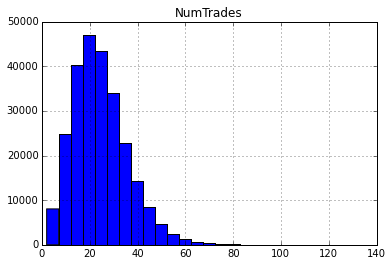

In [131]:
pd.DataFrame(df.NumTrades).hist(bins = 25);

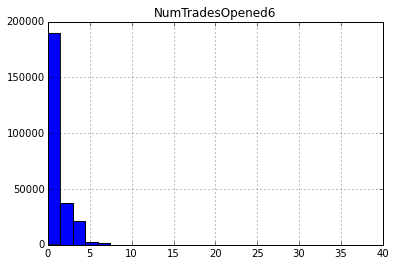

In [132]:
pd.DataFrame(df.NumTradesOpened6).hist(bins = 25);

In [133]:
df.loc[(df['NumTradesOpened6'] >= 12)].ix[:,200:210]

,EnumChannelCode_90000,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6
38441,0,19,13,0,0,0,0,41424,0,1114
62641,1,19,12,0,0,0,1,30653,39283,866
108901,0,58,12,0,0,0,8,146443,0,2156
118292,1,36,13,0,0,0,5,38118,0,1292
162391,0,31,14,0,0,0,0,184559,0,3192
173465,1,60,12,0,0,0,0,133851,0,2407
177951,1,59,12,0,0,0,0,216221,0,3340
178796,0,22,13,0,0,0,0,16281,0,452
184150,1,72,13,0,0,0,0,439599,0,5003
198604,1,30,12,0,0,0,2,34376,6511,774


### There are few outliers for NumTradesOpened6 which are greater than or equal to 12

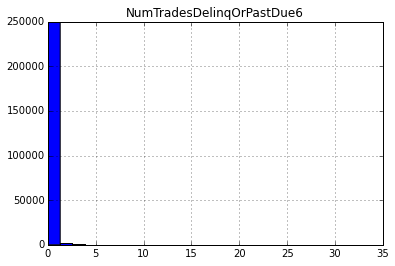

In [134]:
pd.DataFrame(df.NumTradesDelinqOrPastDue6).hist(bins = 25);

In [135]:
df.loc[(df['NumTradesDelinqOrPastDue6'] >= 15)].ix[:,200:210]

,EnumChannelCode_90000,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6
15256,1,48,2,19,0,19,23,150622,0,2378
109839,1,8,1,16,0,16,17,14579,0,373
222529,0,25,0,32,0,32,43,2698,0,231
244959,1,22,0,27,0,27,28,5,0,94


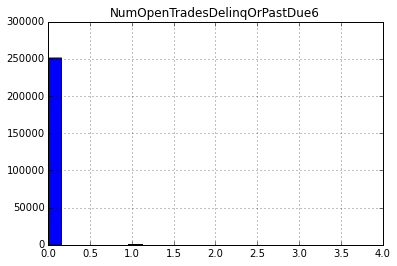

In [136]:
pd.DataFrame(df.NumOpenTradesDelinqOrPastDue6).hist(bins = 25);

In [137]:
df.loc[(df['NumOpenTradesDelinqOrPastDue6'] >= 4)].ix[:,200:210]

,EnumChannelCode_90000,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6
39679,0,29,1,4,4,4,0,461730,0,6300
224056,0,30,0,4,4,4,0,303096,0,3036


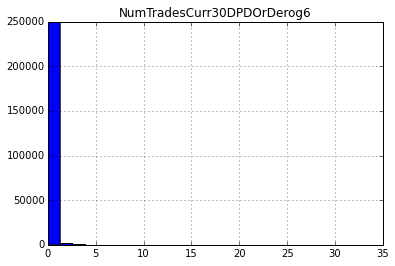

In [138]:
pd.DataFrame(df.NumTradesCurr30DPDOrDerog6).hist(bins = 25);

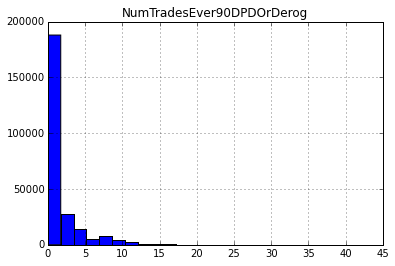

In [139]:
pd.DataFrame(df.NumTradesEver90DPDOrDerog).hist(bins = 25);

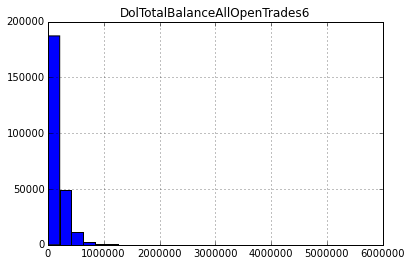

In [140]:
pd.DataFrame(df.DolTotalBalanceAllOpenTrades6).hist(bins = 25);

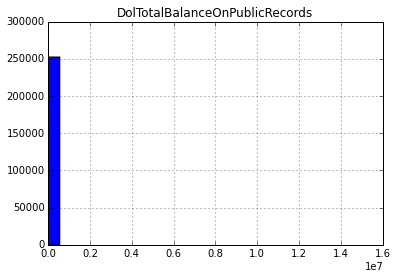

In [141]:
pd.DataFrame(df.DolTotalBalanceOnPublicRecords).hist(bins = 25);

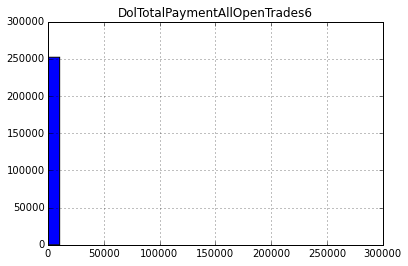

In [142]:
pd.DataFrame(df.DolTotalPaymentAllOpenTrades6).hist(bins = 25);

In [143]:
df.loc[(df['DolTotalPaymentAllOpenTrades6'] >= 50000)].ix[:,180:210]

,NumPriorProsperLoansActive,NumPriorProsperLoans,DolPriorProsperLoansPrincipalBorrowed,DolPriorProsperLoansPrincipalOutstanding,DolPriorProsperLoansBalanceOutstanding,NumPriorProsperLoansCyclesBilled,NumPriorProsperLoansOnTimePayments,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,DolMaxPriorProsperLoan,...,EnumChannelCode_90000,NumTrades,NumTradesOpened6,NumTradesDelinqOrPastDue6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,NumTradesEver90DPDOrDerog,DolTotalBalanceAllOpenTrades6,DolTotalBalanceOnPublicRecords,DolTotalPaymentAllOpenTrades6
12636,0,0,0,0.00,0.00,0,0,0,0,0,...,0,6,0,0,0,0,0,134759,0,134759
120998,0,0,0,0.00,0.00,0,0,0,0,0,...,0,14,1,0,0,2,3,256595,0,177904
170939,0,0,0,0.00,0.00,0,0,0,0,0,...,0,46,4,0,0,0,0,607901,0,192493
196520,1,1,13000,9544.91,9603.72,22,22,0,0,13000,...,0,27,0,0,0,0,0,744764,0,261865


### Some outliers in these columns but all seem real

<hr>
# 6) Examine Sixth set of columns

In [144]:
df.ix[:,210:220].columns.tolist()

['AgeOldestTrade',
 'NumInquiries6MinusLastTwoWeeks',
 'PctTradesNeverDelinquent',
 'NumBankcardTradesOpened12',
 'DolTotalAvailBankcardCredit6',
 'DolTotalBalanceInstallTradesReptd6',
 'NumRealEstateTrades',
 'NumRealPropertyTrades',
 'DolTotalBalanceOpenRevolving6',
 'NumTradesEverDerog']

### Description of Each Column
* `AgeOldestTrade` - 
* `NumInquiries6MinusLastTwoWeeks` - 
* `PctTradesNeverDelinquent` - 
* `NumBankcardTradesOpened12` - 
* `DolTotalAvailBankcardCredit6` - 
* `DolTotalBalanceInstallTradesReptd6` - 
* `NumRealEstateTrades` - 
* `NumRealPropertyTrades` - 
* `DolTotalBalanceOpenRevolving6` - 
* `NumTradesEverDerog` - 

In [145]:
df.ix[:,210:220].head(10)

,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog
0,419,0,96,4,439,0,2,4,33956,0
1,430,0,100,7,9609,142383,2,4,14852,0
2,100,2,86,5,1498,9788,0,0,20802,1
3,60,0,100,3,6050,0,0,0,3100,0
4,237,0,90,4,739,32325,1,2,5519,1
5,326,3,95,10,7634,54948,2,3,66704,1
6,325,2,87,3,9000,41365,2,6,0,3
7,91,0,100,3,9404,8873,0,0,596,0
8,277,0,86,3,1514,29954,3,7,6986,4
9,356,1,100,6,40720,30434,3,6,27429,0


In [146]:
df.ix[:,210:220].describe()

,AgeOldestTrade,NumInquiries6MinusLastTwoWeeks,PctTradesNeverDelinquent,NumBankcardTradesOpened12,DolTotalAvailBankcardCredit6,DolTotalBalanceInstallTradesReptd6,NumRealEstateTrades,NumRealPropertyTrades,DolTotalBalanceOpenRevolving6,NumTradesEverDerog
count,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000
mean,220.986679,0.962976,91.620967,5.426855,13817.552013,24377.678430,1.454230,2.115397,18901.915039,1.276141
std,99.327914,1.206884,10.973948,3.014982,21457.612141,31761.489497,1.616994,2.379252,30299.025671,2.608581
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,153.000000,0.000000,86.000000,3.000000,2600.000000,4044.000000,0.000000,0.000000,5625.000000,0.000000
50%,208.000000,1.000000,96.000000,5.000000,6928.000000,16163.000000,1.000000,2.000000,10677.000000,0.000000
75%,279.000000,2.000000,100.000000,7.000000,16846.000000,32849.000000,2.000000,3.000000,21194.000000,1.000000
max,600.000000,6.000000,100.000000,36.000000,1919750.000000,1179304.000000,33.000000,52.000000,2064331.000000,43.000000


### Are there any missing data in these columns?


In [147]:
pd.isnull(df.ix[:,210:220]).sum()

AgeOldestTrade                        0
NumInquiries6MinusLastTwoWeeks        0
PctTradesNeverDelinquent              0
NumBankcardTradesOpened12             0
DolTotalAvailBankcardCredit6          0
DolTotalBalanceInstallTradesReptd6    0
NumRealEstateTrades                   0
NumRealPropertyTrades                 0
DolTotalBalanceOpenRevolving6         0
NumTradesEverDerog                    0
dtype: int64

### No Missing Data
<hr>
### All other Columns seem reasonable

<hr>
# 7) Examine Seventh set of columns

In [148]:
df.ix[:,220:230].columns.tolist()

['DolMonthlyDebt',
 'NumCurrentDelinquencies',
 'NumDelinquencies84',
 'NumPublicRecordsLast10Years',
 'NumPublicRecords12',
 'DateFirstCredit',
 'NumCreditLines84',
 'NumInquiries6',
 'DolAmountDelinquent',
 'NumCurrentCreditLines']

### Description of Each Column
* `DolMonthlyDebt` - 
* `NumCurrentDelinquencies` - 
* `NumDelinquencies84` - 
* `NumPublicRecordsLast10Years` - 
* `NumPublicRecords12` - 
* `DateFirstCredit` - 
* `NumCreditLines84` - 
* `NumInquiries6` - 
* `DolAmountDelinquent` - 
* `NumCurrentCreditLines` - 

In [149]:
df.ix[:,220:230].head(10)

,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,DateFirstCredit,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines
0,1242,0,1,0,0,1978-11-03 08:00:00,35,0,0,11
1,2289,0,0,0,0,1977-12-01 08:00:00,54,0,0,15
2,911,0,2,0,0,2005-07-19 07:00:00,17,2,0,8
3,223,0,0,0,0,2008-11-04 08:00:00,8,0,0,7
4,1264,1,4,2,0,1994-02-04 08:00:00,43,0,0,11
5,3455,0,4,0,0,1986-09-01 07:00:00,47,4,0,23
6,1488,0,2,1,0,1986-10-03 07:00:00,36,2,0,9
7,308,0,0,0,0,2006-04-11 07:00:00,9,0,0,5
8,846,0,12,1,0,1990-10-05 07:00:00,37,0,0,7
9,1559,0,0,0,0,1984-03-01 08:00:00,35,1,0,13


In [150]:
df.ix[:,220:230].describe()

,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines
count,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000
mean,1095.666982,0.277908,4.142071,0.293772,0.004619,27.898292,1.200631,854.711069,11.493698
std,765.493373,0.954442,10.357197,0.664579,0.078775,12.926266,1.512348,11111.446238,5.245156
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000
25%,570.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,8.000000
50%,936.000000,0.000000,0.000000,0.000000,0.000000,26.000000,1.000000,0.000000,11.000000
75%,1436.000000,0.000000,2.000000,0.000000,0.000000,35.000000,2.000000,0.000000,14.000000
max,27404.000000,44.000000,99.000000,59.000000,6.000000,133.000000,19.000000,3348000.000000,65.000000


### Are there any missing data in these columns?


In [151]:
pd.isnull(df.ix[:,220:230]).sum()

DolMonthlyDebt                 0
NumCurrentDelinquencies        0
NumDelinquencies84             0
NumPublicRecordsLast10Years    0
NumPublicRecords12             0
DateFirstCredit                0
NumCreditLines84               0
NumInquiries6                  0
DolAmountDelinquent            0
NumCurrentCreditLines          0
dtype: int64

### No Missing Data in these columns

In [152]:
df.loc[(df['DolAmountDelinquent'] >= 500000)].ix[:,220:230]

,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,DateFirstCredit,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines
16896,1866,2,41,0,0,1987-03-02 08:00:00,23,3,3348000,10
126846,952,2,6,0,0,1979-01-01 08:00:00,41,4,539087,16
128158,1368,2,14,0,0,1988-03-02 08:00:00,16,0,560721,7
169828,1492,1,15,1,0,1995-11-16 08:00:00,32,1,2297108,11


### There are couple of outliers but these seem real

## Split DateFirstCredit into separate Date Features

In [153]:
## DateFirstCredit
df['DateFirstCredit_Year'] = df.DateFirstCredit.apply(lambda x: x.split('-')[0]).astype(double)
df['DateFirstCredit_Month'] = df.DateFirstCredit.apply(lambda x: x.split('-')[1]).astype(double)
df['DateFirstCredit_Day'] = df.DateFirstCredit.apply(lambda x: x.split('-')[2]).apply(lambda x: x.split(' ')[0]).astype(double)

In [154]:
# rearrange columns so new columns are adjacent to the original features
cols = df.columns.tolist()
cols =  cols[0:225] + cols[-3:] + cols[225:-3]
df = df[cols]

In [155]:
# Drop DateFirstCredit Column
df.drop(['DateFirstCredit'], inplace=True, axis=1)

In [156]:
df.ix[:,220:232].head()

,DolMonthlyDebt,NumCurrentDelinquencies,NumDelinquencies84,NumPublicRecordsLast10Years,NumPublicRecords12,DateFirstCredit_Year,DateFirstCredit_Month,DateFirstCredit_Day,NumCreditLines84,NumInquiries6,DolAmountDelinquent,NumCurrentCreditLines
0,1242,0,1,0,0,1978,11,3,35,0,0,11
1,2289,0,0,0,0,1977,12,1,54,0,0,15
2,911,0,2,0,0,2005,7,19,17,2,0,8
3,223,0,0,0,0,2008,11,4,8,0,0,7
4,1264,1,4,2,0,1994,2,4,43,0,0,11


<hr>
# 8) Examine Eighth set of columns

In [157]:
df.ix[:,230:240].columns.tolist()

['DolAmountDelinquent',
 'NumCurrentCreditLines',
 'NumOpenCreditLines',
 'PctBankcardUtil',
 'NumOpenRevolvingAccounts',
 'DolRealEstateBalance',
 'DolRevolvingBalance',
 'DolRealEstatePayment',
 'NumTotalInquiries',
 'NumSatisfactoryAccounts']

### Description of Each Column
* `NumOpenCreditLines` - 
* `PctBankcardUtil` - 
* `NumOpenRevolvingAccounts` - 
* `DolRealEstateBalance` - 
* `DolRevolvingBalance` - 
* `DolRealEstatePayment` - 
* `NumTotalInquiries` - 
* `NumSatisfactoryAccounts` - 
* `NumWasDelinquentDerog` - 
* `NumDelinquenciesOver30Days` - 

In [158]:
df.ix[:,230:240].head(10)

,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts
0,0,11,8,0.97,7,87475,52941,583,5,33
1,0,15,14,0.48,10,541060,17064,2611,3,53
2,0,8,7,0.93,5,0,20802,0,5,15
3,0,7,7,0.26,7,0,3100,0,1,8
4,0,11,11,0.81,9,0,5558,0,17,39
5,0,23,21,0.87,22,330480,82028,2498,8,45
6,0,9,8,0.00,5,106160,0,705,8,30
7,0,5,5,0.05,5,0,839,0,1,9
8,0,7,6,0.82,4,0,6986,0,8,31
9,0,13,11,0.37,10,240674,27429,1419,3,35


In [159]:
df.ix[:,230:240].describe()

,DolAmountDelinquent,NumCurrentCreditLines,NumOpenCreditLines,PctBankcardUtil,NumOpenRevolvingAccounts,DolRealEstateBalance,DolRevolvingBalance,DolRealEstatePayment,NumTotalInquiries,NumSatisfactoryAccounts
count,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000
mean,854.711069,11.493698,10.690919,0.552458,8.658898,103668.334107,20696.845764,789.460659,5.227123,25.410508
std,11111.446238,5.245156,4.942692,0.263588,4.629546,158696.631271,34411.213851,1469.236407,4.350420,12.261932
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,7.000000,0.360000,5.000000,0.000000,6075.000000,0.000000,2.000000,17.000000
50%,0.000000,11.000000,10.000000,0.570000,8.000000,0.000000,11602.000000,0.000000,4.000000,24.000000
75%,0.000000,14.000000,13.000000,0.770000,11.000000,169603.250000,23154.000000,1323.750000,7.000000,32.000000
max,3348000.000000,65.000000,61.000000,3.430000,66.000000,5913717.000000,3446129.000000,261026.000000,66.000000,133.000000


### Are there any missing data in these columns?


In [160]:
pd.isnull(df.ix[:,230:240]).sum()

DolAmountDelinquent         0
NumCurrentCreditLines       0
NumOpenCreditLines          0
PctBankcardUtil             0
NumOpenRevolvingAccounts    0
DolRealEstateBalance        0
DolRevolvingBalance         0
DolRealEstatePayment        0
NumTotalInquiries           0
NumSatisfactoryAccounts     0
dtype: int64

### No Missing Data
<hr>
### There are couple of outliers but these seem real

<hr>
# 9) Examine Ninth (and Last) set of columns

In [161]:
df.ix[:,240:247].columns.tolist()

['NumWasDelinquentDerog',
 'NumDelinquenciesOver30Days',
 'NumDelinquenciesOver60Days',
 'BoolOwnsHome',
 'EnumLoanFractionalType',
 'DateWholeLoanStart',
 'DateWholeLoanEnd']

### Description of Each Column
* `NumDelinquenciesOver60Days` - 
* `BoolOwnsHome` - 
* `EnumLoanFractionalType` - 
* `DateWholeLoanStart` - 
* `DateWholeLoanEnd` - 
* `BoolEverWholeLoan` - 
* `BoolIsFractionalLoan` - 

In [162]:
df.ix[:,240:247].head(10)

,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd
0,2,8,1,True,3,2014-01-26 18:28:42.477000,NaN
1,1,2,1,True,2,2014-01-09 23:49:48.150000,NaN
2,2,3,2,False,1,NaN,NaN
3,0,0,0,False,3,2014-01-02 23:47:33.943000,NaN
4,3,7,5,False,1,NaN,NaN
5,2,5,2,True,3,2014-01-09 15:50:28.617000,NaN
6,6,4,5,True,3,2014-01-02 15:30:27.903000,NaN
7,0,0,0,False,2,2014-01-02 15:30:28.487000,NaN
8,6,5,4,False,2,2014-01-09 15:50:28.880000,NaN
9,0,0,0,True,1,NaN,NaN


In [163]:
df.ix[:,240:247].describe()

,NumWasDelinquentDerog,NumDelinquenciesOver30Days,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType
count,252458.000000,252458.000000,252458.000000,252458,252458.000000
mean,2.208518,3.294267,1.652849,0.492601,2.549141
std,3.437106,6.372555,3.672253,0.499946,0.684432
min,0.000000,0.000000,0.000000,False,1.000000
25%,0.000000,0.000000,0.000000,0,2.000000
50%,1.000000,1.000000,0.000000,0,3.000000
75%,3.000000,4.000000,2.000000,1,3.000000
max,45.000000,99.000000,99.000000,True,3.000000


### Are there any missing data in these columns?


In [164]:
pd.isnull(df.ix[:,240:247]).sum()

NumWasDelinquentDerog              0
NumDelinquenciesOver30Days         0
NumDelinquenciesOver60Days         0
BoolOwnsHome                       0
EnumLoanFractionalType             0
DateWholeLoanStart             19592
DateWholeLoanEnd              245968
dtype: int64

<hr>
### Convert to Boolean data type `BoolOwnsHome ` to integer

In [165]:
df['BoolOwnsHome'].dtypes

dtype('bool')

In [166]:
df['BoolOwnsHome'] = df['BoolOwnsHome'].astype(int)

In [167]:
df['BoolOwnsHome'].head()

0    1
1    1
2    0
3    0
4    0
Name: BoolOwnsHome, dtype: int32

### Examine EnumLoanFractionalType 

In [168]:
# First check Unique Values in EnumLoanFractionalType
pd.unique(df.EnumLoanFractionalType.ravel())

array([3, 2, 1], dtype=int64)

### Most likely some type of classification with ordinal value

In [169]:
EnumLoanFractionalType_dummies = pd.get_dummies(df['EnumLoanFractionalType'], prefix='EnumLoanFractionalType')
# adding 3 additional columns 

In [170]:
df = pd.concat([df, EnumLoanFractionalType_dummies], axis=1)

In [171]:
df.head()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,NumDelinquenciesOver60Days,BoolOwnsHome,EnumLoanFractionalType,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan,EnumLoanFractionalType_1,EnumLoanFractionalType_2,EnumLoanFractionalType_3
0,973605,105,2013,10,13,6,286,41,0,0,...,1,1,3,2014-01-26 18:28:42.477000,NaN,True,False,0,0,1
1,981099,86,2013,10,15,1,288,42,0,0,...,1,1,2,2014-01-09 23:49:48.150000,NaN,True,False,0,1,0
2,1025766,76,2013,11,6,2,310,45,0,0,...,2,0,1,NaN,NaN,False,True,1,0,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,0,0,3,2014-01-02 23:47:33.943000,NaN,True,False,0,0,1
4,1011335,59,2013,11,11,0,315,46,0,0,...,5,0,1,NaN,NaN,False,True,1,0,0


In [172]:
# Drop EnumLoanFractionalType Column
df.drop(['EnumLoanFractionalType'], inplace=True, axis=1)

In [173]:
# step_1.drop(['dummy', 'c'], inplace=True, axis=1)
#  we want to get rid of one dummy variable to avoid the dummy variable trap
# arbitrarily can chose "EnumListingCategory_0", coefficients on the other columns would show effect of these features
# relative to "EnumListingCategory_0"

In [174]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:242] + cols[-3:] + cols[242:-3]
df = df[cols]

### Examine DateWholeLoanStart and DateWholeLoanEnd

In [175]:
# Using property NaN != NaN
df.loc[(df['DateWholeLoanStart'] != df['DateWholeLoanStart'])].ix[:,242:250].head(10)

,EnumLoanFractionalType_1,EnumLoanFractionalType_2,EnumLoanFractionalType_3,NumDelinquenciesOver60Days,BoolOwnsHome,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan
2,1,0,0,2,0,NaN,NaN,False
4,1,0,0,5,0,NaN,NaN,False
9,1,0,0,0,1,NaN,NaN,False
12,1,0,0,0,0,NaN,NaN,False
16,1,0,0,2,1,NaN,NaN,False
21,1,0,0,2,0,NaN,NaN,False
24,1,0,0,1,0,NaN,NaN,False
42,1,0,0,0,1,NaN,NaN,False
45,1,0,0,0,1,NaN,NaN,False
53,1,0,0,4,0,NaN,NaN,False


### Determine why this data is missing
* Appears that missing Data is because these are Fractional Loans and Not whole Loans
* EnumLoanFractionalType_1 appears to be 1 - Fractional Loan
* BoolIsFractionalLoan appears to be False

In [176]:
df.loc[(df['DateWholeLoanStart'] != df['DateWholeLoanStart']) & df['EnumLoanFractionalType_1'] == 1].ix[:,242:247].count()

EnumLoanFractionalType_1      19592
EnumLoanFractionalType_2      19592
EnumLoanFractionalType_3      19592
NumDelinquenciesOver60Days    19592
BoolOwnsHome                  19592
dtype: int64

### Confirms that DateWholeLoanStart data is missing because these are Fractional Loans
* Fractional Loans do not depend upon DateWholeLoanStart and DateWholeLoanEnd so set to 0

In [177]:
# Using property NaN != NaN
df.loc[(df['DateWholeLoanEnd'] == df['DateWholeLoanEnd'])].ix[:,240:250].head()

,NumWasDelinquentDerog,NumDelinquenciesOver30Days,EnumLoanFractionalType_1,EnumLoanFractionalType_2,EnumLoanFractionalType_3,NumDelinquenciesOver60Days,BoolOwnsHome,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan
57,0,0,1,0,0,0,0,2014-01-03 23:37:56.937000,2014-01-04 00:45:00.970000,True
68,1,0,1,0,0,0,1,2014-01-30 15:28:58.170000,2014-01-30 16:45:03.240000,True
108,1,1,1,0,0,0,1,2014-01-26 18:28:42.920000,2014-01-26 19:45:00.923000,True
154,1,2,1,0,0,0,1,2014-01-07 15:13:02.097000,2014-01-07 16:45:11.207000,True
167,0,0,1,0,0,0,0,2014-01-08 23:46:34.877000,2014-01-09 00:45:02.080000,True


In [178]:
df.loc[(df['DateWholeLoanEnd'] == df['DateWholeLoanEnd'])].ix[:,240:250].count()

NumWasDelinquentDerog         6490
NumDelinquenciesOver30Days    6490
EnumLoanFractionalType_1      6490
EnumLoanFractionalType_2      6490
EnumLoanFractionalType_3      6490
NumDelinquenciesOver60Days    6490
BoolOwnsHome                  6490
DateWholeLoanStart            6490
DateWholeLoanEnd              6490
BoolEverWholeLoan             6490
dtype: int64

In [179]:
df.shape

(252458, 251)

### However, there are some EnumLoanFractionalType_1 =1 Loans which have both DateWholeLoanStart and DateWholeLoanEnd with BoolEverWholeLoan and BoolIsFractionalLoan are True
* So story is more complicated
* 245968 + 6490 = 252458 so this explains missing data in DateWholeLoanEnd

### Fill NaNs with 0's and Split up into Date Features

In [180]:
df['DateWholeLoanStart'] = df.DateWholeLoanStart.fillna(value='0-0-0 ')

In [181]:
df.ix[:,244:260].head(10)

,EnumLoanFractionalType_3,NumDelinquenciesOver60Days,BoolOwnsHome,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan
0,1,1,1,2014-01-26 18:28:42.477000,NaN,True,False
1,0,1,1,2014-01-09 23:49:48.150000,NaN,True,False
2,0,2,0,0-0-0,NaN,False,True
3,1,0,0,2014-01-02 23:47:33.943000,NaN,True,False
4,0,5,0,0-0-0,NaN,False,True
5,1,2,1,2014-01-09 15:50:28.617000,NaN,True,False
6,1,5,1,2014-01-02 15:30:27.903000,NaN,True,False
7,0,0,0,2014-01-02 15:30:28.487000,NaN,True,False
8,0,4,0,2014-01-09 15:50:28.880000,NaN,True,False
9,0,0,1,0-0-0,NaN,False,True


In [182]:
## DateWholeLoanStart
df['DateWholeLoanStart_Year'] = df.DateWholeLoanStart.apply(lambda x: x.split('-')[0]).astype(double)
df['DateWholeLoanStart_Month'] = df.DateWholeLoanStart.apply(lambda x: x.split('-')[1]).astype(double)
df['DateWholeLoanStart_Day'] = df.DateWholeLoanStart.apply(lambda x: x.split('-')[2]).apply(lambda x: x.split(' ')[0]).astype(double)

In [183]:
df['DateWholeLoanEnd'] = df.DateWholeLoanEnd.fillna(value='0-0-0 ')

In [184]:
## DateWholeLoanEnd
df['DateWholeLoanEnd_Year'] = df.DateWholeLoanEnd.apply(lambda x: x.split('-')[0]).astype(double)
df['DateWholeLoanEnd_Month'] = df.DateWholeLoanEnd.apply(lambda x: x.split('-')[1]).astype(double)
df['DateWholeLoanEnd_Day'] = df.DateWholeLoanEnd.apply(lambda x: x.split('-')[2]).apply(lambda x: x.split(' ')[0]).astype(double)

In [185]:
df.ix[:,245:270].head(10)

,NumDelinquenciesOver60Days,BoolOwnsHome,DateWholeLoanStart,DateWholeLoanEnd,BoolEverWholeLoan,BoolIsFractionalLoan,DateWholeLoanStart_Year,DateWholeLoanStart_Month,DateWholeLoanStart_Day,DateWholeLoanEnd_Year,DateWholeLoanEnd_Month,DateWholeLoanEnd_Day
0,1,1,2014-01-26 18:28:42.477000,0-0-0,True,False,2014,1,26,0,0,0
1,1,1,2014-01-09 23:49:48.150000,0-0-0,True,False,2014,1,9,0,0,0
2,2,0,0-0-0,0-0-0,False,True,0,0,0,0,0,0
3,0,0,2014-01-02 23:47:33.943000,0-0-0,True,False,2014,1,2,0,0,0
4,5,0,0-0-0,0-0-0,False,True,0,0,0,0,0,0
5,2,1,2014-01-09 15:50:28.617000,0-0-0,True,False,2014,1,9,0,0,0
6,5,1,2014-01-02 15:30:27.903000,0-0-0,True,False,2014,1,2,0,0,0
7,0,0,2014-01-02 15:30:28.487000,0-0-0,True,False,2014,1,2,0,0,0
8,4,0,2014-01-09 15:50:28.880000,0-0-0,True,False,2014,1,9,0,0,0
9,0,1,0-0-0,0-0-0,False,True,0,0,0,0,0,0


In [186]:
# Drop Date columns since they are no longer needed
df.drop('DateWholeLoanStart', 1, inplace=True)
df.drop('DateWholeLoanEnd', 1, inplace=True)

In [187]:
df.ix[:,245:270].head(10)

,NumDelinquenciesOver60Days,BoolOwnsHome,BoolEverWholeLoan,BoolIsFractionalLoan,DateWholeLoanStart_Year,DateWholeLoanStart_Month,DateWholeLoanStart_Day,DateWholeLoanEnd_Year,DateWholeLoanEnd_Month,DateWholeLoanEnd_Day
0,1,1,True,False,2014,1,26,0,0,0
1,1,1,True,False,2014,1,9,0,0,0
2,2,0,False,True,0,0,0,0,0,0
3,0,0,True,False,2014,1,2,0,0,0
4,5,0,False,True,0,0,0,0,0,0
5,2,1,True,False,2014,1,9,0,0,0
6,5,1,True,False,2014,1,2,0,0,0
7,0,0,True,False,2014,1,2,0,0,0
8,4,0,True,False,2014,1,9,0,0,0
9,0,1,False,True,0,0,0,0,0,0


In [188]:
# rearrange columns so new column is adjacent to the original features
cols = df.columns.tolist()
cols = cols[0:245] + cols[-6:] + cols[245:-6]
df = df[cols]

### Convert to Boolean data types `BoolEverWholeLoan` and `BoolIsFractionalLoan` to integer

In [189]:
df['BoolEverWholeLoan'].dtypes

dtype('bool')

In [190]:
df['BoolEverWholeLoan'] = df['BoolEverWholeLoan'].astype(int)

In [191]:
df['BoolEverWholeLoan'].head()

0    1
1    1
2    0
3    1
4    0
Name: BoolEverWholeLoan, dtype: int32

In [192]:
df['BoolIsFractionalLoan'].dtypes

dtype('bool')

In [193]:
df['BoolIsFractionalLoan'] = df['BoolIsFractionalLoan'].astype(int)

In [194]:
df['BoolIsFractionalLoan'].head()

0    0
1    0
2    1
3    0
4    1
Name: BoolIsFractionalLoan, dtype: int32

In [195]:
df.columns.tolist()

['ListingNumber',
 'DateListingDelay',
 'DateCreditPulled_Year',
 'DateCreditPulled_Month',
 'DateCreditPulled_Day',
 'DateCreditPulled_day_of_week',
 'DateCreditPulled_day_of_year',
 'DateCreditPulled_weekofyear',
 'DateCreditPulled_is_month_start',
 'DateCreditPulled_is_month_end',
 'DateListingStart_Year',
 'DateListingStart_Month',
 'DateListingStart_Day',
 'DateListingStart_day_of_week',
 'DateListingStart_day_of_year',
 'DateListingStart_weekofyear',
 'DateListingStart_is_month_start',
 'DateListingStart_is_month_end',
 'DateListingCreation_Year',
 'DateListingCreation_Month',
 'DateListingCreation_Day',
 'DateListingCreation_day_of_week',
 'DateListingCreation_day_of_year',
 'DateListingCreation_weekofyear',
 'DateListingCreation_is_month_start',
 'DateListingCreation_is_month_end',
 'EnumListingStatus',
 'DolLoanAmountRequested',
 'BoolPartialFundingApproved',
 'CreditGrade',
 'LenderYield',
 'BorrowerRate',
 'NumMonthsTerm',
 'DolMonthlyLoanPayment',
 'FICOScore',
 'ProsperSco

### Move to Last Column for Convenience


In [196]:
cols = df.columns.tolist()
cols = cols[0:26]+ cols[27:] + cols[26:27]
df = df[cols]

# Model Building
* Splitting into Training and Test sets
* Normalization
* k-Folds Cross-Validation

In [197]:
df.head(10)

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,...,DateWholeLoanStart_Month,DateWholeLoanStart_Day,DateWholeLoanEnd_Year,DateWholeLoanEnd_Month,DateWholeLoanEnd_Day,NumDelinquenciesOver60Days,BoolOwnsHome,BoolEverWholeLoan,BoolIsFractionalLoan,EnumListingStatus
0,973605,105,2013,10,13,6,286,41,0,0,...,1,26,0,0,0,1,1,1,0,1
1,981099,86,2013,10,15,1,288,42,0,0,...,1,9,0,0,0,1,1,1,0,1
2,1025766,76,2013,11,6,2,310,45,0,0,...,0,0,0,0,0,2,0,0,1,0
3,1003835,55,2013,11,8,4,312,45,0,0,...,1,2,0,0,0,0,0,1,0,1
4,1011335,59,2013,11,11,0,315,46,0,0,...,0,0,0,0,0,5,0,0,1,0
5,1010105,58,2013,11,11,0,315,46,0,0,...,1,9,0,0,0,2,1,1,0,0
6,1029573,52,2013,11,11,0,315,46,0,0,...,1,2,0,0,0,5,1,1,0,0
7,1014296,50,2013,11,13,2,317,46,0,0,...,1,2,0,0,0,0,0,1,0,0
8,1009580,59,2013,11,11,0,315,46,0,0,...,1,9,0,0,0,4,0,1,0,0
9,743482,297,2013,11,11,0,315,46,0,0,...,0,0,0,0,0,0,1,0,1,1


In [198]:
df.ix[:,0:10].describe()

,ListingNumber,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end
count,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000,252458.000000
mean,1854900.649712,3.227891,2014.243712,6.085697,15.475168,2.661175,169.400827,24.618424,0.029197,0.028127
std,435123.434909,10.786033,0.435532,3.644192,8.616336,1.872914,110.767887,15.743449,0.168359,0.165337
min,743482.000000,-1.000000,2013.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1478967.750000,0.000000,2014.000000,3.000000,8.000000,1.000000,68.000000,10.000000,0.000000,0.000000
50%,1848018.500000,0.000000,2014.000000,6.000000,15.000000,3.000000,163.000000,24.000000,0.000000,0.000000
75%,2216546.500000,1.000000,2014.000000,9.000000,23.000000,4.000000,268.000000,39.000000,0.000000,0.000000
max,2715258.000000,490.000000,2015.000000,12.000000,31.000000,6.000000,365.000000,52.000000,1.000000,1.000000


* Note that ListingNumber is an Index of the listing

In [199]:
df.ix[:,1:-1].head()

,DateListingDelay,DateCreditPulled_Year,DateCreditPulled_Month,DateCreditPulled_Day,DateCreditPulled_day_of_week,DateCreditPulled_day_of_year,DateCreditPulled_weekofyear,DateCreditPulled_is_month_start,DateCreditPulled_is_month_end,DateListingStart_Year,...,DateWholeLoanStart_Year,DateWholeLoanStart_Month,DateWholeLoanStart_Day,DateWholeLoanEnd_Year,DateWholeLoanEnd_Month,DateWholeLoanEnd_Day,NumDelinquenciesOver60Days,BoolOwnsHome,BoolEverWholeLoan,BoolIsFractionalLoan
0,105,2013,10,13,6,286,41,0,0,2014,...,2014,1,26,0,0,0,1,1,1,0
1,86,2013,10,15,1,288,42,0,0,2014,...,2014,1,9,0,0,0,1,1,1,0
2,76,2013,11,6,2,310,45,0,0,2014,...,0,0,0,0,0,0,2,0,0,1
3,55,2013,11,8,4,312,45,0,0,2014,...,2014,1,2,0,0,0,0,0,1,0
4,59,2013,11,11,0,315,46,0,0,2014,...,0,0,0,0,0,0,5,0,0,1


In [200]:
df.ix[:,-1:].head()

,EnumListingStatus
0,1
1,1
2,0
3,1
4,0


### Assign X and y

In [201]:
X, y = df.ix[:,1:-1].values, df.ix[:,-1:].values.ravel()

### Split Data Set into train and test sets

In [202]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size=0.2,
random_state=1)

In [203]:
X_train.shape

(201966, 253)

In [204]:
X_test.shape

(50492, 253)

In [205]:
y_train.shape

(201966,)

In [206]:
y_test.shape

(50492,)

# Train Three different classifiers
* Logistic Regression - LogisticRegression
* Naive Bayes - GaussianNB
* Random Forest - RandomForestClassifier

Train three different classifiers and look at their individual performances via a 10-fold cross-validation on the training datasset before we combine them into an ensemble classifier.

In [207]:
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

In [219]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Logistic Regression with ElasticNet Regularization with stochastic gradient descent (SGD)

In [261]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(alpha=0.0001, loss="log", penalty="elasticnet")
clf.fit(X_train_std, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [265]:
print('Training accuracy:', clf.score(X_train_std, y_train))

Training accuracy: 0.706544665934


In [267]:
print('Test accuracy:', clf.score(X_test_std, y_test))

Test accuracy: 0.708310227363


### Logistic Regression with L1 Regularization

In [263]:
lr = LogisticRegression(random_state=1, penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [264]:
print('Training accuracy:', lr.score(X_train_std, y_train))

Training accuracy: 0.723290058723


In [266]:
print('Test accuracy:', lr.score(X_test_std, y_test))

Test accuracy: 0.722807573477


### Random Forest

In [208]:
df.columns[1:-1]

Index(['DateListingDelay', 'DateCreditPulled_Year', 'DateCreditPulled_Month',
       'DateCreditPulled_Day', 'DateCreditPulled_day_of_week',
       'DateCreditPulled_day_of_year', 'DateCreditPulled_weekofyear',
       'DateCreditPulled_is_month_start', 'DateCreditPulled_is_month_end',
       'DateListingStart_Year',
       ...
       'DateWholeLoanStart_Year', 'DateWholeLoanStart_Month',
       'DateWholeLoanStart_Day', 'DateWholeLoanEnd_Year',
       'DateWholeLoanEnd_Month', 'DateWholeLoanEnd_Day',
       'NumDelinquenciesOver60Days', 'BoolOwnsHome', 'BoolEverWholeLoan',
       'BoolIsFractionalLoan'],
      dtype='object', length=253)

In [209]:
feat_labels = df.columns[1:-1]
# by setting n_jobs=-1, we can use all available CPUs on our machine to do the computation in parallel.
forest = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=3)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [211]:
print('Training accuracy:', forest.score(X_train, y_train))

Training accuracy: 0.999990097343


In [212]:
print('Test accuracy:', forest.score(X_test, y_test))

Test accuracy: 0.719916026301


In [241]:
forest = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [242]:
print('Training accuracy:', forest.score(X_train, y_train))

Training accuracy: 0.999990097343


In [243]:
print('Test accuracy:', forest.score(X_test, y_test))

Test accuracy: 0.722728353006


In [244]:
forest = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [245]:
print('Training accuracy:', forest.score(X_train, y_train))

Training accuracy: 0.999990097343


In [246]:
print('Test accuracy:', forest.score(X_test, y_test))

Test accuracy: 0.724174126594


### Gradient Boosting

In [213]:
from sklearn.ensemble import GradientBoostingClassifier

In [214]:
gbm = GradientBoostingClassifier(n_estimators=200, max_depth=3)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [215]:
print('Training accuracy:', gbm.score(X_train, y_train))

Training accuracy: 0.733138250993


In [217]:
print('Test accuracy:', gbm.score(X_test, y_test))

Test accuracy: 0.732373445298


In [247]:
gbm = GradientBoostingClassifier(n_estimators=500, max_depth=3)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [248]:
print('Training accuracy:', gbm.score(X_train, y_train))

Training accuracy: 0.742659655586


In [249]:
print('Test accuracy:', gbm.score(X_test, y_test))

Test accuracy: 0.738295175473


### Naive Bayes

In [221]:
gnb = GaussianNB()
gnb.fit(X_train_std, y_train)

GaussianNB()

In [222]:
print('Training accuracy:', gnb.score(X_train, y_train))

Training accuracy: 0.350687739521


In [223]:
print('Test accuracy:', gnb.score(X_test, y_test))

Test accuracy: 0.352432068446


### k-Nearest Neighbors

In [224]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [225]:
print('Training accuracy:', knn.score(X_train, y_train))

Training accuracy: 0.52147391145


In [226]:
print('Test accuracy:', knn.score(X_test, y_test))

Test accuracy: 0.521963875465


### Ensemble Learning

In [231]:
from sklearn import linear_model
clf1 = linear_model.SGDClassifier(alpha=0.0001, loss="log", penalty="elasticnet", random_state=1, n_jobs=-1)
clf2 = LogisticRegression(random_state=1, penalty='l1', C=0.1, n_jobs=-1)
clf3 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
clf4 = GradientBoostingClassifier(n_estimators=200, max_depth=3)

# clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
# clf2 = RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=1)
# clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# train the logistic regression classifiers as part of a pipeline. 
# both logistic regression and k-nearest neighbors algorithms 
# (using the Euclidean distance metric) are not scale-invariant in contrast with decision trees.
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', clf2]])

clf_labels = ['SGDClassifier', 'Logistic Regression', 'Random Forest', 'Gradient Boosting']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, pipe2, clf3, clf4], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.67 (+/- 0.01) [SGDClassifier]
ROC AUC: 0.72 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.70 (+/- 0.00) [Random Forest]
ROC AUC: 0.74 (+/- 0.00) [Gradient Boosting]


In [235]:
clf1 = linear_model.SGDClassifier(alpha=0.01, loss="log", penalty="elasticnet", random_state=1, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
clf3 = GradientBoostingClassifier(n_estimators=200, max_depth=3)

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

eclf = VotingClassifier(estimators=[('SGD', pipe1), ('rf', clf2), ('gbm', clf3)], voting='hard')
for clf, label in zip([pipe1, clf2, clf3, eclf], ['SGD', 'Random Forest', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
# Note: predict_proba is not available when voting='hard'
# Note that scikit-learn uses the predict_proba method (if applicable) to compute the ROC AUC score.

Accuracy: 0.72 (+/- 0.00) [SGD]
Accuracy: 0.72 (+/- 0.00) [Random Forest]
Accuracy: 0.73 (+/- 0.00) [Gradient Boosting]
Accuracy: 0.73 (+/- 0.00) [Ensemble]


### Randomized search for hyperparameter estimation

In [240]:
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV

# Random Forest classifier
clf = RandomForestClassifier(n_estimators=150, n_jobs=-1)

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 588.51 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.666 (std: 0.000)
Parameters: {'max_depth': 3, 'bootstrap': False, 'max_features': 1, 'min_samples_split': 1, 'min_samples_leaf': 8, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.666 (std: 0.000)
Parameters: {'max_depth': 3, 'bootstrap': False, 'max_features': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.666 (std: 0.000)
Parameters: {'max_depth': 3, 'bootstrap': True, 'max_features': 7, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}



### Tuning hyperparameters via grid search

* Below commands executed on another machine to expedite computations

In [ ]:
# from sklearn.grid_search import GridSearchCV
# pipe_SGD = Pipeline([('scl', StandardScaler()), ('clf', linear_model.SGDClassifier(random_state=1))])
# param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
# param_grid = [{'clf__alpha': param_range,
#                'clf__loss': ['log'],
#                'clf__penalty': ['elasticnet']}]
# gs = GridSearchCV(estimator=pipe_SGD,
#                param_grid=param_grid,
#                scoring='accuracy',
#                cv=10,
#                n_jobs=-1)
# gs = gs.fit(X_train, y_train)
# print(gs.best_score_)
# print(gs.best_params_)

In [ ]:
# 0.717249438024
# {'clf__penalty': 'elasticnet', 'clf__loss': 'log', 'clf__alpha': 0.01}

### Random Forest

In [ ]:
# from sklearn.grid_search import GridSearchCV
# clf = RandomForestClassifier(random_state=1)
# param_range = [50, 100, 150, 200, 250, 500]
# param_grid = [{'n_estimators': param_range}]
# rf = GridSearchCV(estimator=clf,
#                param_grid=param_grid,
#                scoring='accuracy',
#                cv=10,
#                n_jobs=-1)
# rf = rf.fit(X_train, y_train)
# print(rf.best_score_)
# print(rf.best_params_)

In [ ]:
# 0.944188625808
# {'n_estimators': 150}

### Gradient Boosting

In [251]:
# from sklearn.grid_search import GridSearchCV
# clf = GradientBoostingClassifier(max_depth=3)
# param_range = [50, 125, 250]
# param_grid = [{'n_estimators': param_range}]
# gbm = GridSearchCV(estimator=clf,
#                param_grid=param_grid,
#                scoring='accuracy',
#                cv=10,
#                n_jobs=-1)
# gbm = gbm.fit(X_train, y_train)
# print(gbm.best_score_)
# print(gbm.best_params_)

In [252]:
# 0.732464870325
# {'n_estimators': 250}

### Randomized Grid Search for Random Forest

In [ ]:
# from sklearn.grid_search import RandomizedSearchCV
# from time import time
# from operator import itemgetter
# from scipy.stats import randint as sp_randint
# # build a classifier
# clf = RandomForestClassifier(n_estimators=20)

# # Utility function to report best scores
# def report(grid_scores, n_top=3):
#     top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
#     for i, score in enumerate(top_scores):
#         print("Model with rank: {0}".format(i + 1))
#         print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#               score.mean_validation_score,
#               np.std(score.cv_validation_scores)))
#         print("Parameters: {0}".format(score.parameters))
#         print("")


# # specify parameters and distributions to sample from
# param_dist = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# # run randomized search
# n_iter_search = 20
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search)

# start = time()
# random_search.fit(X, y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# report(random_search.grid_scores_)

### Voting Classifier

In [250]:
clf1 = linear_model.SGDClassifier(alpha=0.01, loss="log", penalty="elasticnet", random_state=1, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=-1)
clf3 = GradientBoostingClassifier(n_estimators=250, max_depth=3)

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

eclf = VotingClassifier(estimators=[('SGD', pipe1), ('rf', clf2), ('gbm', clf3)], voting='soft', weights=[1,1,1.5])
for clf, label in zip([pipe1, clf2, clf3, eclf], ['SGD', 'Random Forest', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.713 (+/- 0.003) [SGD]
Accuracy: 0.704 (+/- 0.003) [Random Forest]
Accuracy: 0.742 (+/- 0.002) [Gradient Boosting]
Accuracy: 0.736 (+/- 0.002) [Ensemble]


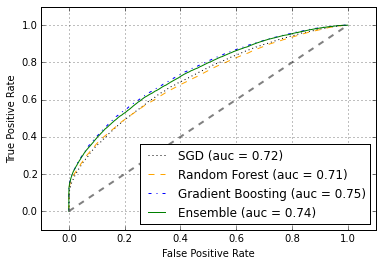

In [253]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
all_clf = [pipe1, clf2, clf3, eclf]
clf_labels = ['SGD', 'Random Forest', 'Gradient Boosting', 'Ensemble']
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()